In [1]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
import scipy as sp
from scipy import linalg
import cairosvg
from PIL import Image


In [2]:
from matplotlib import animation, rc
from IPython.display import HTML

# Get data

In [3]:
#pull these from hdf5
s_df3 = pd.read_hdf('Data/Fig2_3_S3.hdf5', 's_df3')
s_df6 = pd.read_hdf('Data/Fig2_3_S3.hdf5', 's_df6')
s_df7 = pd.read_hdf('Data/Fig2_3_S3.hdf5', 's_df7')
s_df13 = pd.read_hdf('Data/Fig2_3_S3.hdf5', 's_df13')


# Plot RFs of individual ROIs

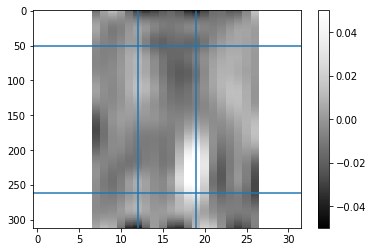

In [4]:
#full RF of individual ROI used in fig 2B
roi_num = 10 #examples used: off: 19, 715, ; on: 10, 1020,
plt.imshow(s_df13['shifted_filters'].iloc[roi_num], aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
plt.colorbar()

axes=plt.gca()
axes.axhline(50)
axes.axhline(s_df13['shifted_filters'].iloc[roi_num].shape[0]-50)
axes.axvline(12)
axes.axvline(19)


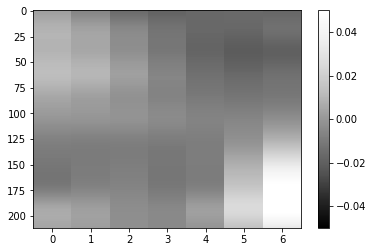

In [5]:
# cropped RF used for clustering
roi_num = 10 #examples used: off: 19, 715, ; on: 10, 1020,
plt.imshow(s_df13['shifted_filters'].iloc[roi_num][50:-50, 12:19], aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
plt.colorbar()

plt.show()

In [6]:
#pull the variables that are needed from this
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig2_3_S3.hdf5", "r")

#get the data for plotting the sd image

roimask = np.array(f1['roimask'])
x_zoom = np.array(f1['x_zoom'])
z_zoom = np.array(f1['z_zoom'])
roi_list_all = np.array(f1['roi_list_all'])
center_pixels = np.array(f1['center_pixels'])
dataCh0 = np.array(f1['dataCh0'])


f1.close()

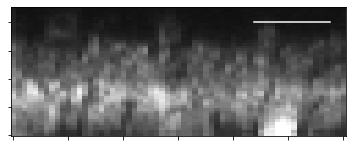

In [7]:
std = np.std(dataCh0, axis=2)
avg = np.mean(dataCh0, axis=2)
aspect = ((71.5/std.shape[0])/x_zoom)/((61.6/std.shape[1])/z_zoom) #for plotting to scale

plt.imshow(avg.T[10:, 3:], aspect=1/aspect, cmap='Greys_r', origin='lower', vmin=10943, vmax=10958)
axes = plt.gca()
axes.set_yticklabels([])
axes.set_xticklabels([])

start_pos = 40
length_um = 25
total_length = 71.5/x_zoom
start_pos_x = 80
plt.axhline(y=start_pos, xmin=start_pos_x/total_length, xmax=(start_pos_x+length_um)/total_length, color='white') #need to figure out scale bar


plt.show()

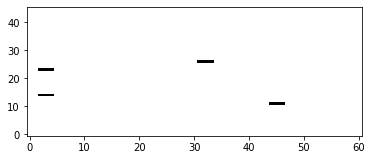

In [8]:
#show where these pixels are
dsmap0 = roimask*(-1)*1000
xlength = dsmap0.shape[0]
ylength = dsmap0.shape[1]

for i, rois in enumerate(roi_list_all):

    for x in range(xlength):
        for y in range(ylength):  
            if dsmap0[x,y]/1000 in rois:
                dsmap0[x,y] = i+1
#             elif dsmap0[x,y]<0:
#                 dsmap0[x,y] = -1
#             else:
#                 dsmap0[x,y] = np.nan

dsmap0_final = np.where(dsmap0>999, np.nan, dsmap0)
dsmap0_final = np.where(dsmap0_final<0, np.nan, dsmap0_final)
# fig=plt.figure()
plt.imshow(dsmap0_final.T[10:, 3:], cmap='Greys_r', origin='lower', vmin=8, vmax=9, aspect=1/aspect) #cmap='Dark2', 


# Prepare for Clustering

In [9]:
s_df_xz = pd.concat([s_df3, s_df6, s_df7, s_df13])

In [10]:
#flattening
splines = np.asarray(s_df_xz['shifted_filters'])
spline_array = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 212*7))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[50:-50,12:19]
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [11]:
#flattening the other way too
splines = np.asarray(s_df_xz['shifted_filters'])

spline_array_orderC = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten()#order='F')
    spline_array_orderC[i,:] = current_spline_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

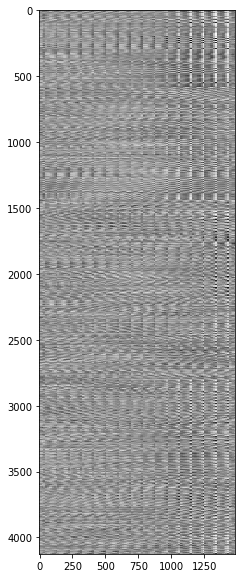

In [12]:
fig = plt.figure(figsize=(10,10))
plt.imshow(spline_array_cropped, cmap='Greys_r')

# Figpath = 'Fig_temp/'
# savename = Figpath+"spline_array_cropped.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [13]:
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

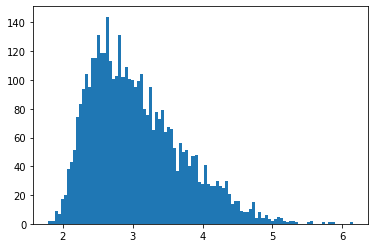

In [14]:
plt.hist(np.amax(np.abs(zscored_spline_array), axis=1), bins=100)
plt.show()

In [15]:
threshold = 2.5
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

In [16]:
s_df_xz_masked = s_df_xz.iloc[quality_mask].copy()

# Clustering

In [17]:
# #this is the code for clustering. Cluster assignments found here are already stored in the hdf5 file
# # next this clustering is run and cluster assignments are stored in the database.
# # we can just pull the cluster assignments from the database


# x = np.copy(spline_array_cropped[quality_mask[0],:])

# #sparsify the RFs
# transformer = SparsePCA(n_components=7, alpha=0.3, random_state=0) #, random_state=0 #(sets random seed)
# transformer.fit(x)
# x_transformed = transformer.transform(x)
# x_transformed.shape

# np.mean(transformer.components_ == 0)

# n_components = 4
# components_ = transformer.components_
# images = components_[:n_components]

# image_shape = (212,7)

# for i, comp in enumerate(images):
#     fig = plt.figure()
#     plt.imshow(comp.reshape(image_shape), cmap='Greys_r',
#                        interpolation='nearest', aspect='auto')#,vmin=-vmax, vmax=vmax)
    
# #     Figpath = 'Fig_temp/'
# #     savename = Figpath+"sparce_pca_reconstructioned_"+str(i)+".pdf"
# #     plt.savefig(savename, transparent=True, bbox_inches='tight')

# # x_transformed_ipl = np.concatenate((x_transformed, np.expand_dims(s_df_xz_masked['depth'], axis=1)), axis=1)

# x_transformed_ipl = np.concatenate((x_transformed[:,:4], np.expand_dims(s_df_xz_masked['depth'], axis=1)), axis=1)

# #determine number of clusters using BIC
# K = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16,17, 18, 19,]
# BIC = np.zeros((3,len(K)))
# LL = np.zeros((3,len(K)))


# # run mog and BIC multiple times
# for i, kk in enumerate(K):
#     print(kk)
#     for j in np.arange(0,3):
#         gm = GaussianMixture(n_components=kk, random_state=0, covariance_type='diag',
#                     init_params='kmeans')
#         fit = gm.fit(x_transformed_ipl)
#         bic = gm.bic(x_transformed_ipl)
#         BIC[j,i] = bic

# #plot the BIC as a function of # of clusters
# plt.figure(figsize=(5, 4))

# plt.plot(K,np.min(BIC,axis=0),'s', color='k')
# plt.xlabel('Number of clusters')
# plt.ylabel('BIC')
# plt.xticks(K)
# # plt.xlim((1,7))

# # Figpath = 'Fig_temp/'
# # savename = Figpath+"MoG_BIC_.pdf"
# # plt.savefig(savename, transparent=True, bbox_inches='tight')

# plt.show()



# #final fit using cluster selected from above
# gm = GaussianMixture(n_components=13, random_state=0, covariance_type='diag',
#                     init_params='kmeans')
# fit = gm.fit(x_transformed_ipl)
# labels = gm.predict(x_transformed_ipl)
# s_df_xz_masked['new_cluster_assignment'] = labels

In [18]:
#pull from hdf5 file
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig2_3_S3.hdf5", "r")

#get the data for plotting the sd image
cluster_assignments = np.array(f1['cluster_assignments'])
f1.close()

In [19]:
s_df_xz_masked['new_cluster_assignment'] = cluster_assignments

# Evaluating Clustering and measuring cluster parameters

In [20]:
#make average filters
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

average_filters = np.zeros((s_df_xz_masked['shifted_filters'].iloc[0].shape[0], s_df_xz_masked['shifted_filters'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = s_df_xz_masked[s_df_xz_masked['new_cluster_assignment']==clust]    
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters']), axis=2)
    average_filters[:,:,i] = current_mean
    

#make SD of filters
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

sd_filters = np.zeros((s_df_xz_masked['shifted_filters'].iloc[0].shape[0], s_df_xz_masked['shifted_filters'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = s_df_xz_masked[s_df_xz_masked['new_cluster_assignment']==clust]    
    current_sd = np.nanstd(np.dstack(current_frame['shifted_filters']), axis=2)
    sd_filters[:,:,i] = current_sd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [21]:
# find the cluster average depth
s_df_xz_copy = s_df_xz_masked.copy(deep=True)
s_df_xz_copy = s_df_xz_copy.set_index(['new_cluster_assignment'])

cluster_avg_depth = s_df_xz_copy['depth'].groupby(['new_cluster_assignment']).mean()

# get the IPL depth order for plotting
original_clusters = cluster_avg_depth.index
ipl_depth_order = cluster_avg_depth.sort_values().index

s_df_xz_masked['new_cluster_assignment_sorted'] = s_df_xz_masked['new_cluster_assignment'].replace(
    original_clusters, ipl_depth_order)

# ding et al Chat bands (fig 2):
#means are similar to ZZ's paper but the range is larger.
off_top = 0.80
off_bottom = 0.65
off_mean = (off_top+off_bottom)/2

on_top = 0.25
on_bottom = 0.40
on_mean = (on_top+on_bottom)/2

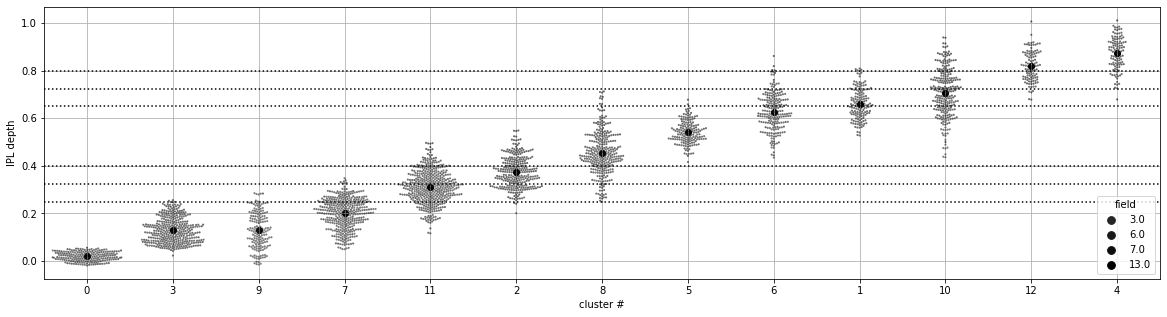

In [22]:
#plot clusters by IPL depth
n_bins = 10
current_palette = sns.color_palette()

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = s_df_xz['field']

fig=plt.figure(figsize=(20,5))


ax = sns.swarmplot(data=s_df_xz_masked, x="new_cluster_assignment", y="depth", hue="field",
                   alpha=0.6, color='k', size=2.1, order=ipl_depth_order)
# plt.scatter(s_df_xz['new_cluster_assignment'], s_df_xz['depth'], alpha=0.3, c=c, cmap=cm)
# plt.colorbar()
plt.scatter(cluster_avg_depth.index, cluster_avg_depth[ipl_depth_order], color='k')

axes = plt.gca()
axes.axhline(on_top, linestyle='dotted', color='k')
axes.axhline(on_bottom, linestyle='dotted', color='k')
axes.axhline(on_mean, linestyle='dotted', color='k')
axes.axhline(off_top, linestyle='dotted', color='k')
axes.axhline(off_bottom, linestyle='dotted', color='k')
axes.axhline(off_mean, linestyle='dotted', color='k')
axes.set_xlabel('cluster #')
axes.set_ylabel('IPL depth')
plt.grid(True)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_ipl_depth_chat.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

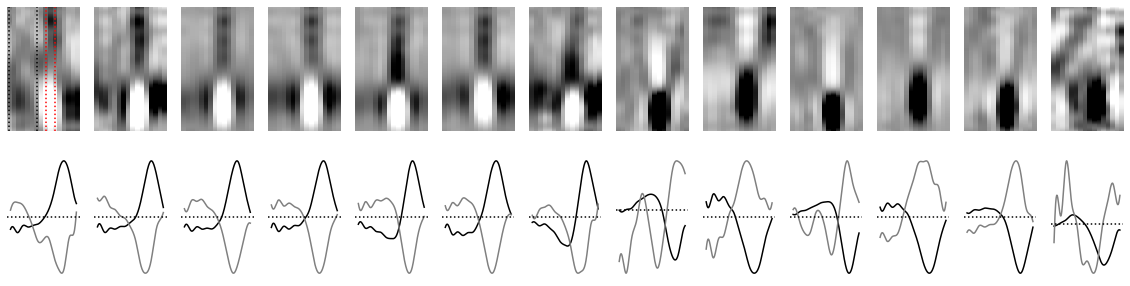

In [23]:
#plot the cluster averages and normalized temporal kernels and calculate latency and surround strength

polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
latency = np.zeros(len(polarity))
surround_strength = np.zeros(len(polarity))
fig, ax = plt.subplots(2, 13, figsize=(20, 5))
for i, clust in enumerate(ipl_depth_order):
    
#     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12, cmap='Greys_r')
#     ax[0, i].set_yticklabels([])
#     ax[0, i].set_xticklabels([])
#     ax[0, i].axis('off')
    
    ax[0, i].imshow(average_filters[15:-15,10:26,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
    if i == 0:
        ax[0, i].axvline(10-10, color='k', linestyle='dotted')
        ax[0, i].axvline(16-10, color='k', linestyle='dotted')
        ax[0, i].axvline(18-10, color='r', linestyle='dotted')
        ax[0, i].axvline(20-10, color='r', linestyle='dotted')
    ax[0, i].axis('off')
    
    avg_filter_flipped = average_filters[:,:,clust]*polarity[clust] #deal with off cells

    ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='k',)
    ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:-15,10:17], axis=1))*-1, color='grey')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[1, i].axhline(color='k', linestyle='dotted')
    ax[1, i].set_yticklabels([])
    ax[1, i].set_xticklabels([])
    ax[1, i].axis('off')
    
#     Figpath = 'Fig_temp/'
#     savename = Figpath+"Cluster_avgs_"+str(i)+".pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')

#     plt.show()
    center = np.mean(avg_filter_flipped[150:280,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[150:280,18:21], axis=1))
    surround = np.mean(avg_filter_flipped[150:280,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:280,10:17], axis=1))
    latency[clust] = np.argmax(center)-np.argmax(surround) 
    surround_strength[clust] = np.amin(np.mean(avg_filter_flipped[100:280,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped[100:280,18:21], axis=1))

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_avgs.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

In [24]:
# #plot the cluster averages and normalized temporal kernels and calculate latency and surround strength
# # here the surround is normalized to the center by reviewer request

# polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
# latency = np.zeros(len(polarity))
# surround_strength = np.zeros(len(polarity))
# fig, ax = plt.subplots(2, 13, figsize=(20, 5))
# for i, clust in enumerate(ipl_depth_order):
    
# #     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12, cmap='Greys_r')
# #     ax[0, i].set_yticklabels([])
# #     ax[0, i].set_xticklabels([])
# #     ax[0, i].axis('off')
    
#     ax[0, i].imshow(average_filters[15:-15,10:26,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
#                     aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
#     if i == 0:
#         ax[0, i].axvline(10-10, color='k', linestyle='dotted')
#         ax[0, i].axvline(16-10, color='k', linestyle='dotted')
#         ax[0, i].axvline(18-10, color='r', linestyle='dotted')
#         ax[0, i].axvline(20-10, color='r', linestyle='dotted')
#     ax[0, i].axis('off')
    
#     avg_filter_flipped = average_filters[:,:,clust]*polarity[clust] #deal with off cells

#     ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='k',)
# #     ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,10:17], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='grey')
#     ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,14:17], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='grey')
# #     ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,23:26], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='r')
#     #     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
#     ax[1, i].axhline(color='k', linestyle='dotted')
#     ax[1, i].set_yticklabels([])
#     ax[1, i].set_xticklabels([])
#     ax[1, i].axis('off')
    
# #     Figpath = 'Fig_temp/'
# #     savename = Figpath+"Cluster_avgs_"+str(i)+".pdf"
# #     plt.savefig(savename, transparent=True, bbox_inches='tight')

# #     plt.show()
# #     center = np.mean(avg_filter_flipped[150:280,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[150:280,18:21], axis=1))
# #     surround = np.mean(avg_filter_flipped[150:280,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:280,10:17], axis=1))
# #     latency[clust] = np.argmax(center)-np.argmax(surround) 
# #     surround_strength[clust] = np.amin(np.mean(avg_filter_flipped[100:280,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped[100:280,18:21], axis=1))

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_avgs.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

# plt.show()
    

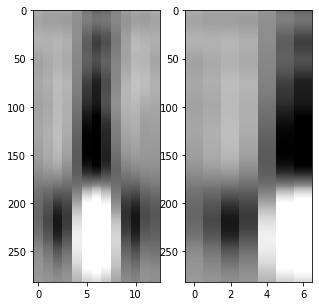

In [25]:
#example cropped filter, On
clust = 11

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(average_filters[15:-15,13:26,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)

ax[1].imshow(average_filters[15:-15,13:20,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_11_convolution.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

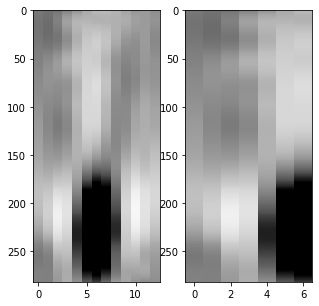

In [26]:
#example cropped filter, Off
clust = 12

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(average_filters[15:-15,13:26,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)

ax[1].imshow(average_filters[15:-15,13:20,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_12_convolution.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [27]:
# np.save('average_filters_by_cluster.npy', average_filters)

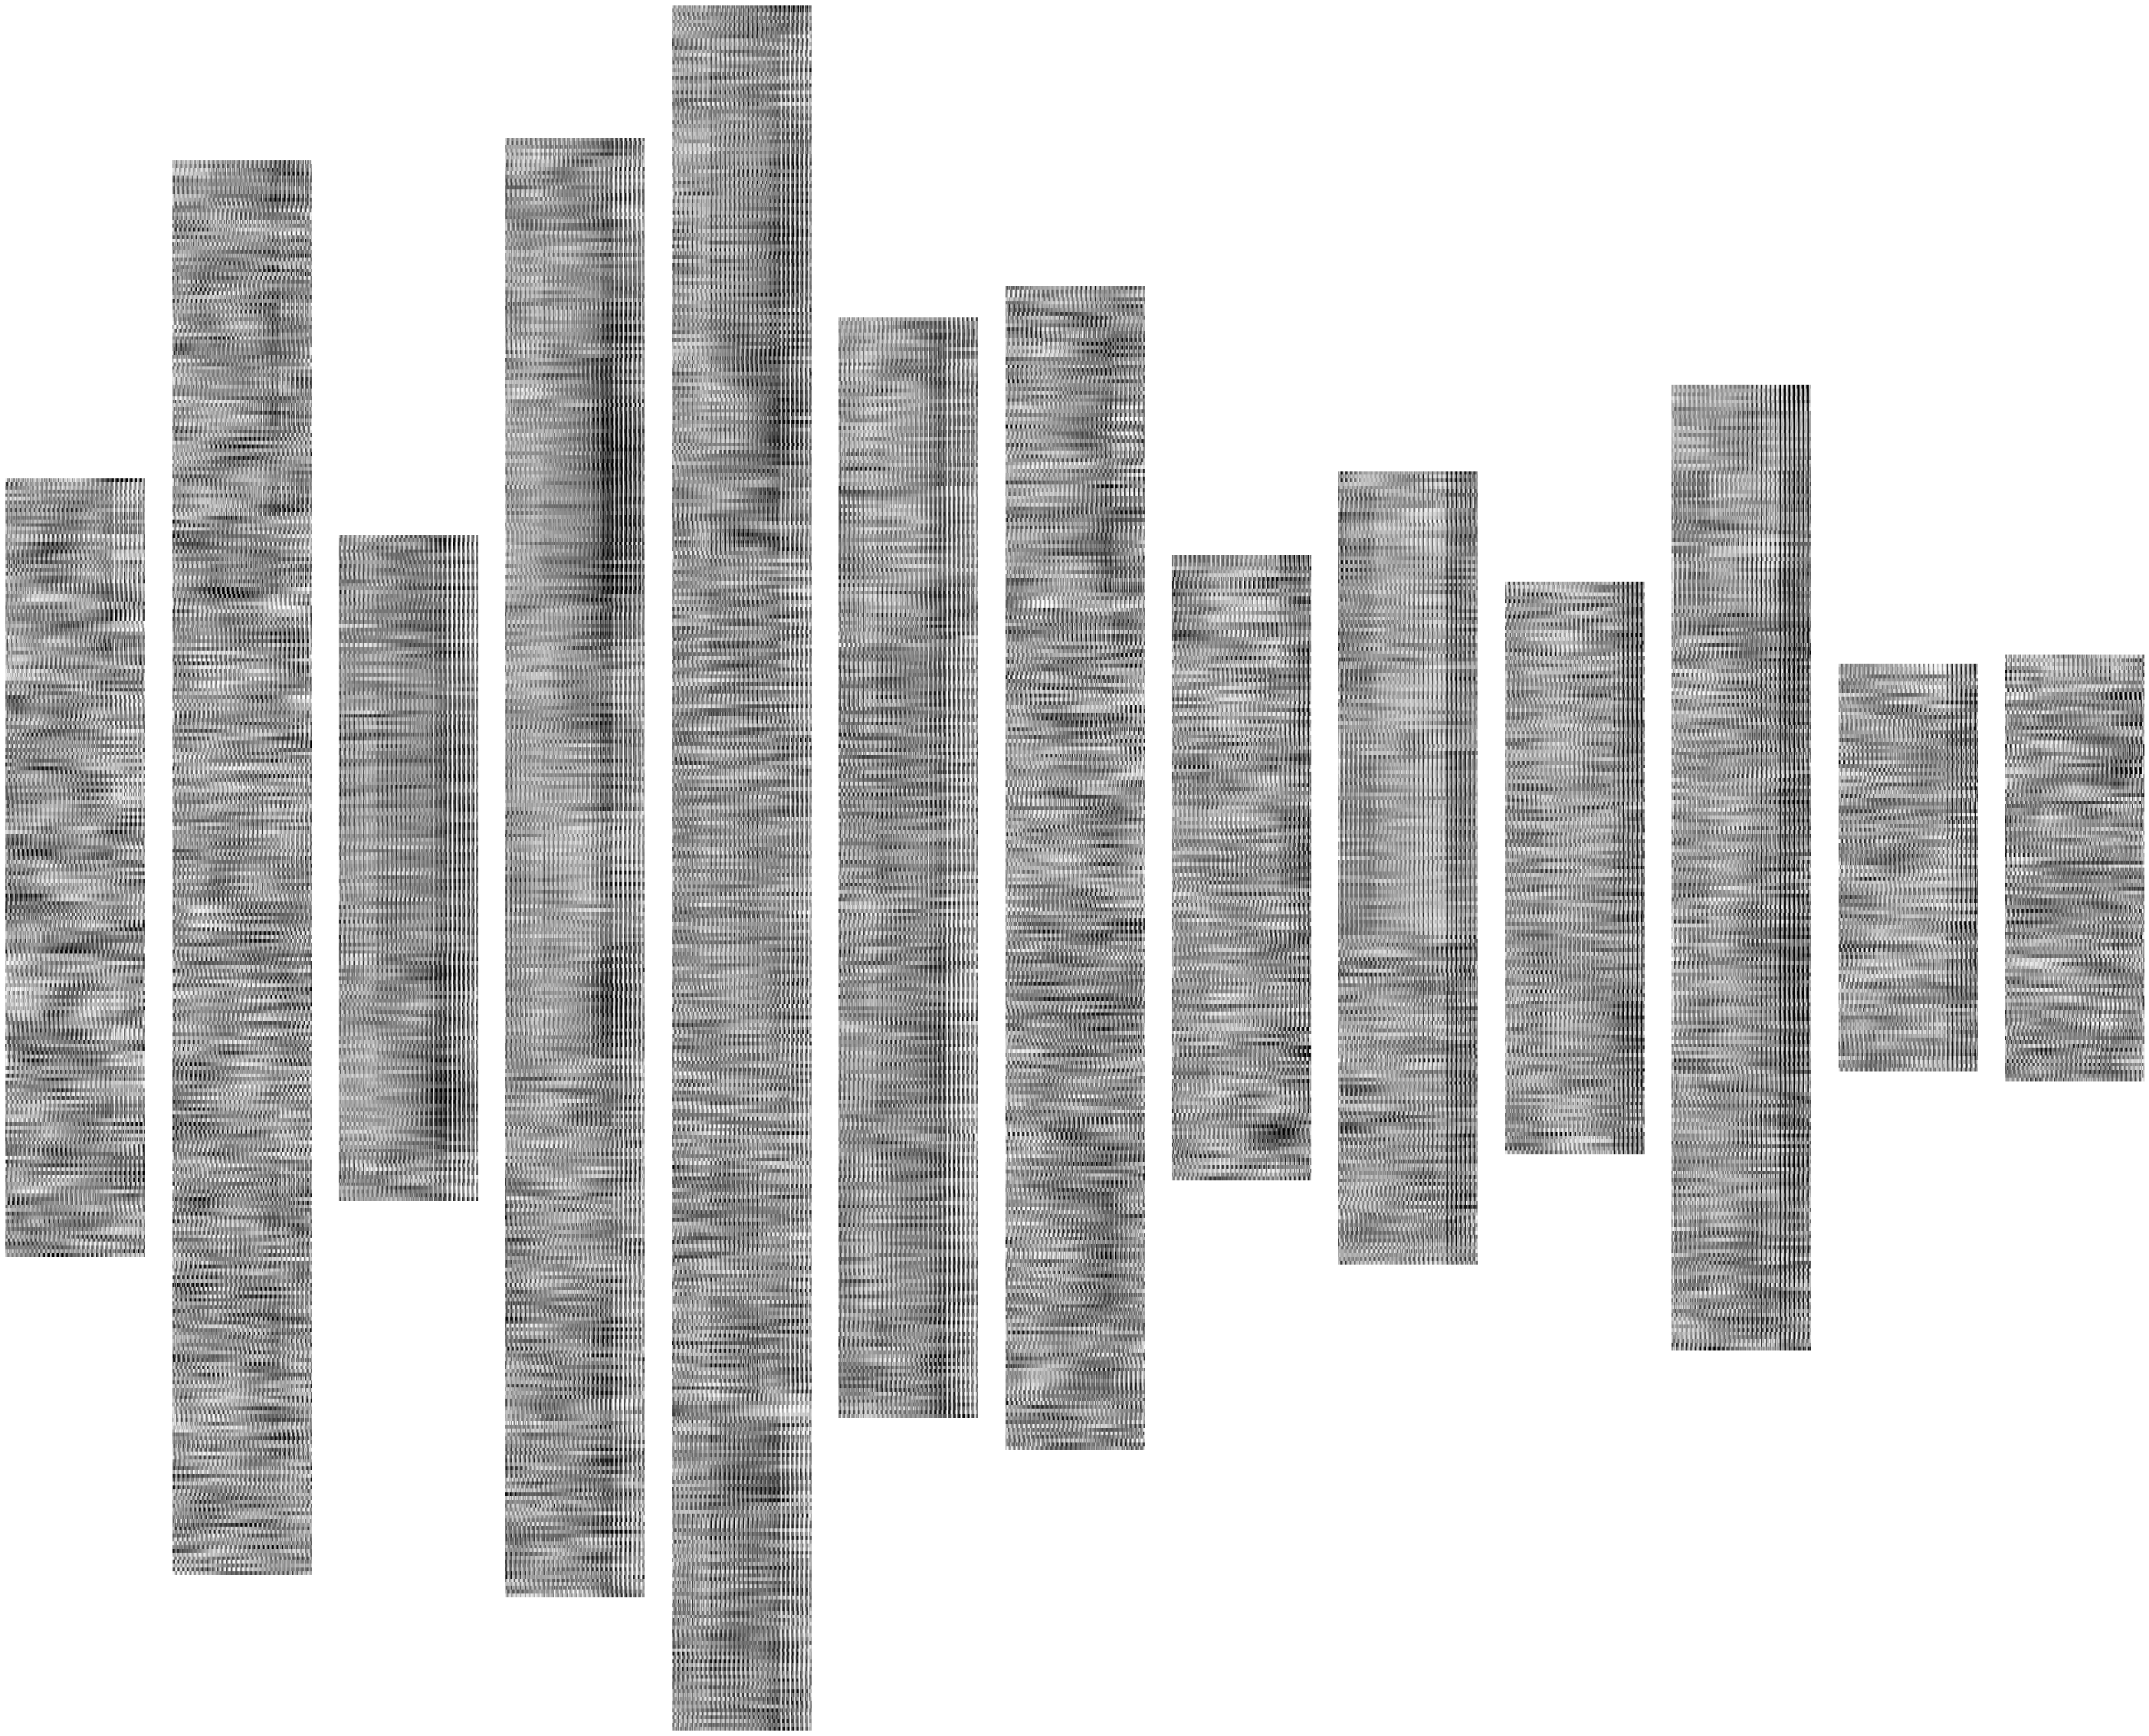

In [28]:
# flattened responses by cluster
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]

fig, ax = plt.subplots(1, 13, figsize=(50, 50))
for i, clust in enumerate(ipl_depth_order):
    
    ax[i].imshow(spline_array_cropped[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], cmap='Greys_r', aspect=40, vmin=-0.03, vmax=0.03) 
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_orderC.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

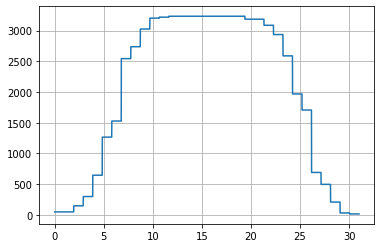

In [29]:
#check the density of the data at different spatial positions
data_hist = np.count_nonzero(~np.isnan(spline_array[quality_mask[0],:]), axis=0)

#number of samples across space
xvals=np.linspace(0, 31, data_hist.shape[0])
plt.plot(xvals, data_hist)
plt.grid(True)

In [30]:
# response in center vs. surround for each individual ROI

center_single_rois = np.nanmean(np.dstack(s_df_xz_masked['shifted_filters'])[:,18:21,:], axis=1)
surround_single_rois = np.nanmean(np.dstack(s_df_xz_masked['shifted_filters'])[:,10:17,:], axis=1)

(208, 282)
(378, 282)
(178, 282)
(390, 282)
(461, 282)
(294, 282)
(311, 282)


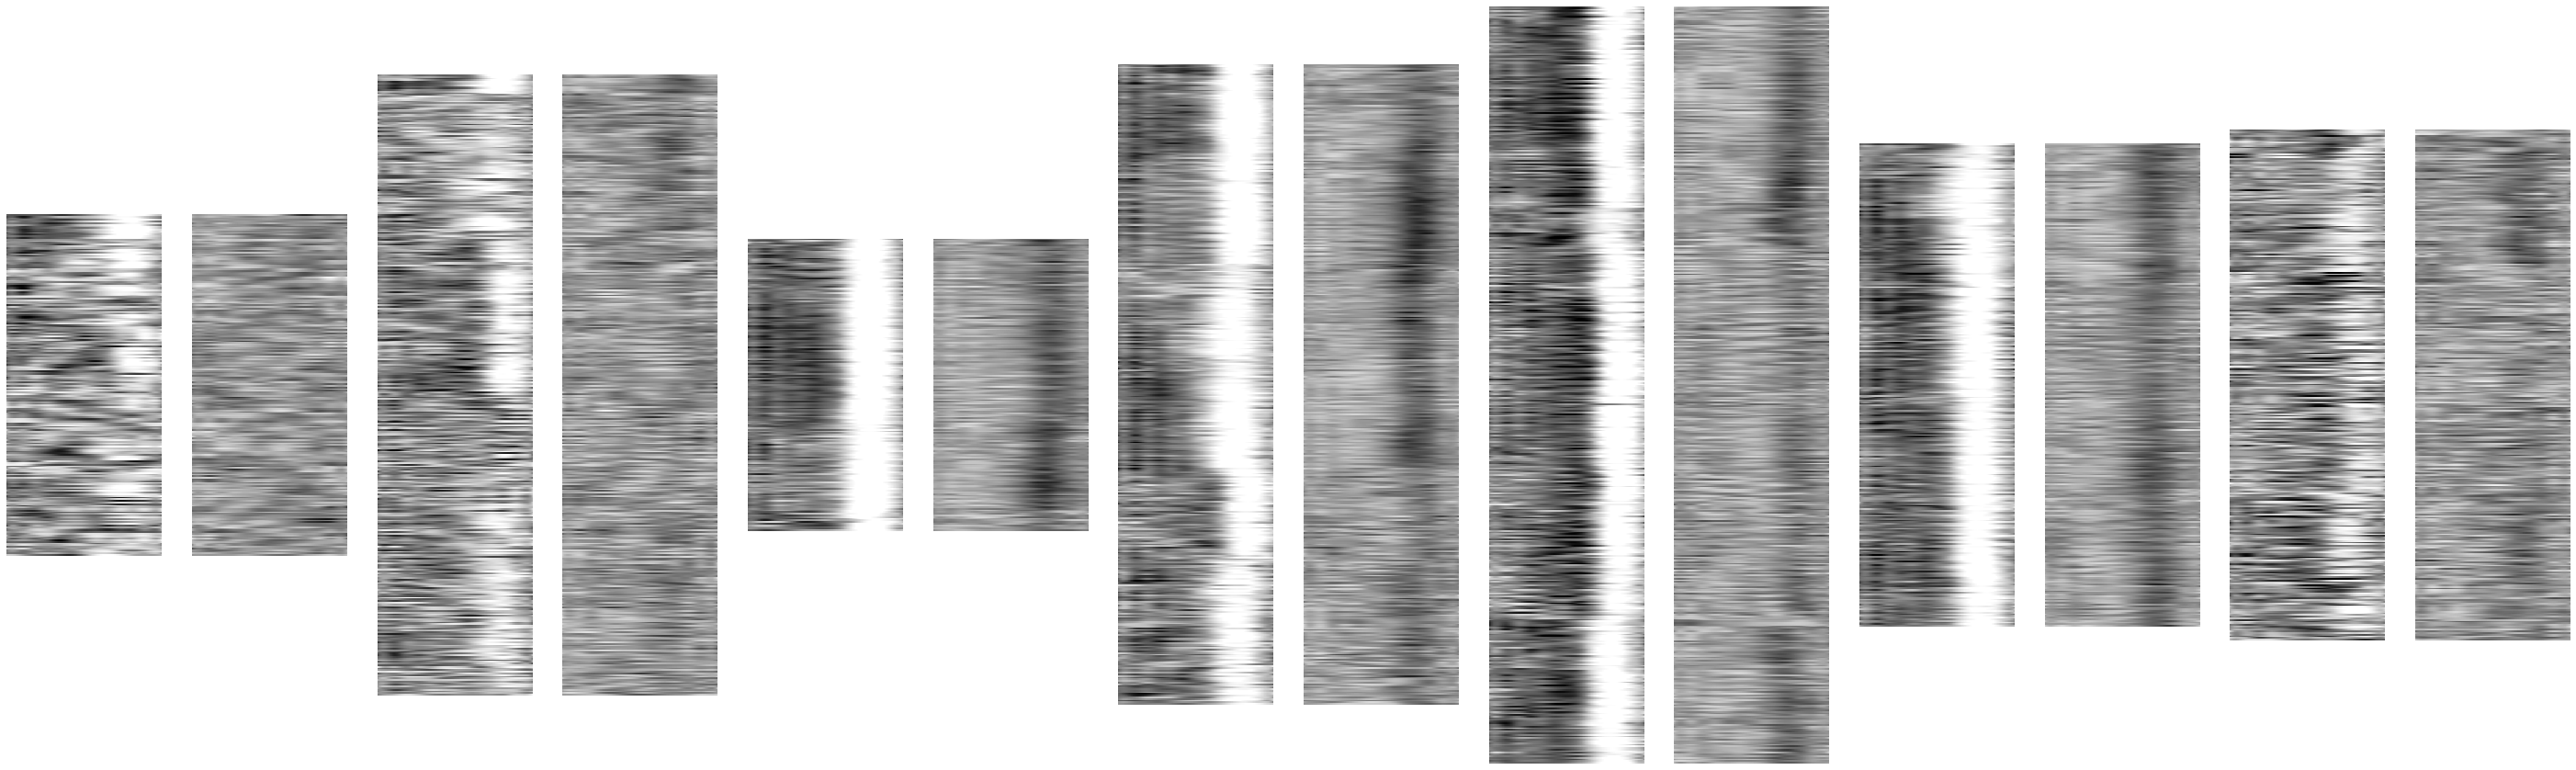

In [31]:
#on clusters, temporal kernels in center and surround
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]

range_vals = 0.03

fig, ax = plt.subplots(1, 14, figsize=(50, 50))
for i, clust in enumerate(ipl_depth_order):
    if polarity[clust]==1:
        ax[2*i].imshow(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust].T, cmap='Greys_r', aspect=3, vmin=-range_vals, vmax=range_vals) 
        ax[2*i].set_yticklabels([])
        ax[2*i].set_xticklabels([])
        ax[2*i].axis('off')
        print(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust].T.shape)
        
        ax[2*i+1].imshow(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust].T, cmap='Greys_r', aspect=3, vmin=-range_vals, vmax=range_vals) 
        ax[2*i+1].set_yticklabels([])
        ax[2*i+1].set_xticklabels([])
        ax[2*i+1].axis('off')
    
#     ax[i, 1].imshow(surround_single_rois[:, s_df_xz_masked['new_cluster_assignment']==clust].T, cmap='Greys_r', aspect=1, vmin=-range_vals, vmax=range_vals) 
#     ax[i, 1].set_yticklabels([])
#     ax[i, 1].set_xticklabels([])
#     ax[i, 1].axis('off')
    

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_individual_roi_centre_surrounds_ON.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

(167, 282)
(212, 282)
(153, 282)
(258, 282)
(109, 282)
(114, 282)


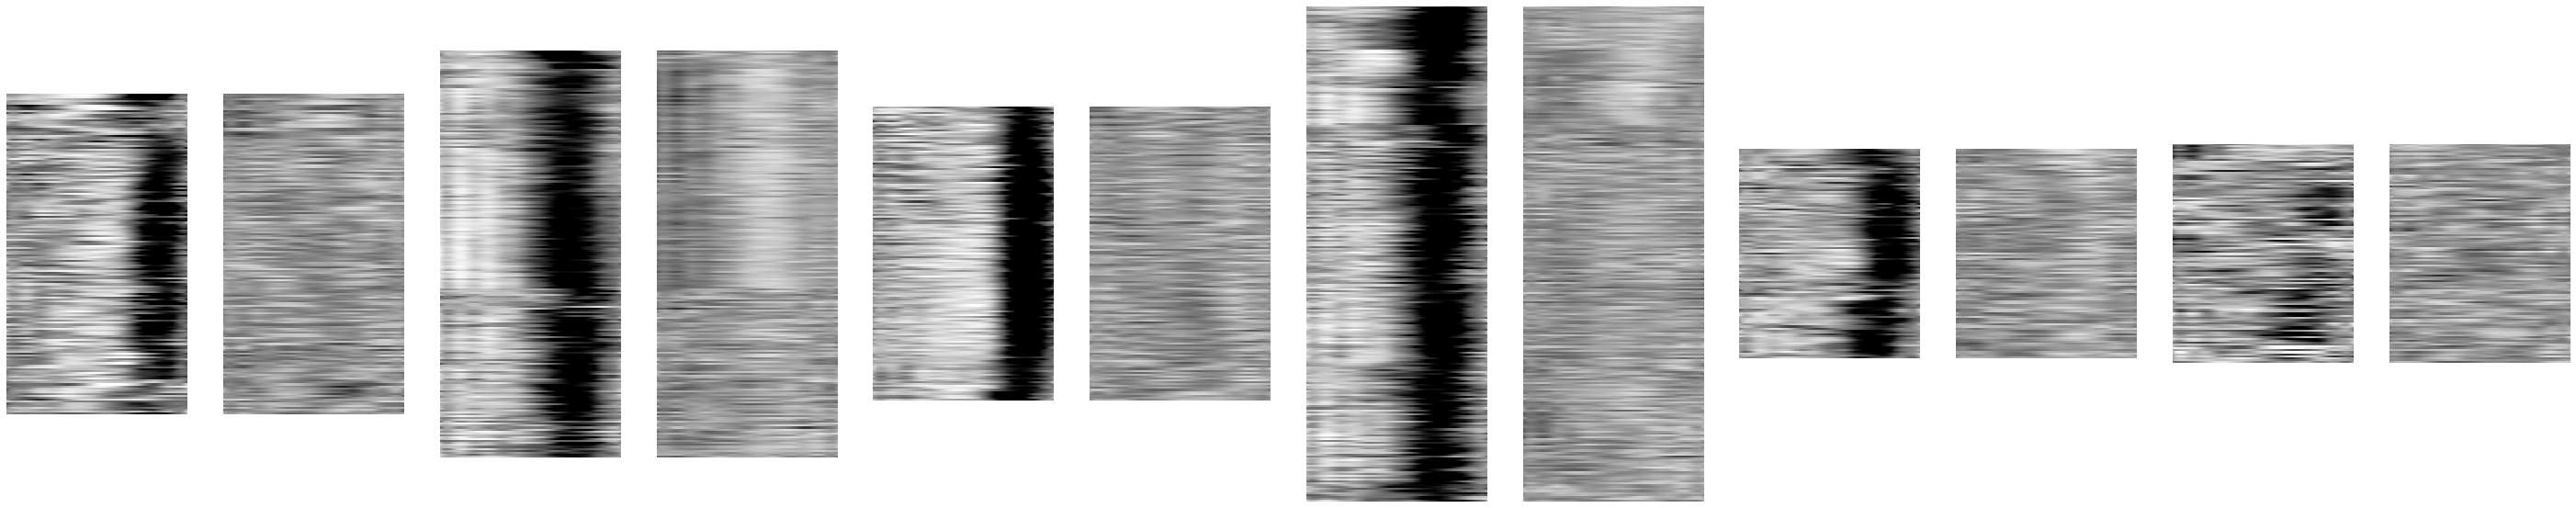

In [32]:
#off clusters, temporal kernels in center and surround
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]

range_vals = 0.03

fig, ax = plt.subplots(1, 12, figsize=(50, 50))
for i, clust in enumerate(ipl_depth_order):
    if polarity[clust]==-1:
        ax[2*i-14].imshow(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust].T, cmap='Greys_r', aspect=3, vmin=-range_vals, vmax=range_vals) 
        ax[2*i-14].set_yticklabels([])
        ax[2*i-14].set_xticklabels([])
        ax[2*i-14].axis('off')
        print(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust].T.shape)
        
        ax[2*i+1-14].imshow(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust].T, cmap='Greys_r', aspect=3, vmin=-range_vals, vmax=range_vals) 
        ax[2*i+1-14].set_yticklabels([])
        ax[2*i+1-14].set_xticklabels([])
        ax[2*i+1-14].axis('off')
    
#     ax[i, 1].imshow(surround_single_rois[:, s_df_xz_masked['new_cluster_assignment']==clust].T, cmap='Greys_r', aspect=1, vmin=-range_vals, vmax=range_vals) 
#     ax[i, 1].set_yticklabels([])
#     ax[i, 1].set_xticklabels([])
#     ax[i, 1].axis('off')
    

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_individual_roi_centre_surrounds_OFF.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

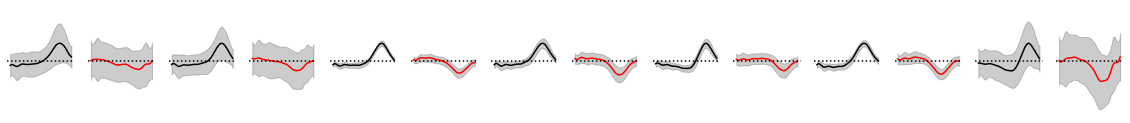

In [33]:
#on clusters average temporal kernels in center and surround
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]

range_vals = 0.025

fig, ax = plt.subplots(1, 14, figsize=(20, 2))
for i, clust in enumerate(ipl_depth_order):    
    
    if polarity[clust]==1:
    
        center_mean = np.mean(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
        surround_mean = np.mean(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)

        center_sd = np.std(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
        surround_sd = np.std(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
        xvals = np.arange(center_mean.shape[0])


        center_max = np.amax(center_mean)
        if polarity[clust] == -1:
            center_min = np.amin(center_mean)
            center_max=-center_min
        range_y_top = center_max*3
        range_y_bottom = center_max*3


        ax[2*i].plot(center_mean, color='k',)
        ax[2*i].fill_between(xvals, center_mean+center_sd, center_mean-center_sd, alpha=0.2, color='k')
        ax[2*i].axhline(color='k', linestyle='dotted')
        ax[2*i].set_ylim([-range_y_bottom, range_y_top])
        ax[2*i].set_yticklabels([])
        ax[2*i].set_xticklabels([])
        ax[2*i].axis('off')


        range_y_top = center_max*1.2
        range_y_bottom = center_max*1.2

        ax[2*i+1].plot(surround_mean, color='r')
        ax[2*i+1].fill_between(xvals, surround_mean+surround_sd, surround_mean-surround_sd, alpha=0.2, color='k')
        ax[2*i+1].axhline(color='k', linestyle='dotted')
        ax[2*i+1].set_ylim([-range_y_bottom, range_y_top])
        ax[2*i+1].set_yticklabels([])
        ax[2*i+1].set_xticklabels([])
        ax[2*i+1].axis('off')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_center_surround_avgs_stds_ON.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

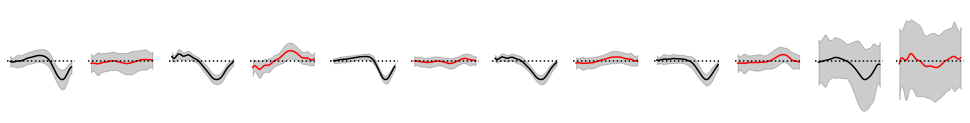

In [34]:
#off clusters, average temporal kernels in center and surround
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]

range_vals = 0.025

fig, ax = plt.subplots(1, 12, figsize=(17.14, 2))
for i, clust in enumerate(ipl_depth_order):    
    
    if polarity[clust]==-1:
    
        center_mean = np.mean(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
        surround_mean = np.mean(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)

        center_sd = np.std(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
        surround_sd = np.std(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
        xvals = np.arange(center_mean.shape[0])


        center_max = np.amax(center_mean)
        if polarity[clust] == -1:
            center_min = np.amin(center_mean)
            center_max=-center_min
        range_y_top = center_max*3
        range_y_bottom = center_max*3


        ax[2*i-14].plot(center_mean, color='k',)
        ax[2*i-14].fill_between(xvals, center_mean+center_sd, center_mean-center_sd, alpha=0.2, color='k')
        ax[2*i-14].axhline(color='k', linestyle='dotted')
        ax[2*i-14].set_ylim([-range_y_bottom, range_y_top])
        ax[2*i-14].set_yticklabels([])
        ax[2*i-14].set_xticklabels([])
        ax[2*i-14].axis('off')


        range_y_top = center_max*1.2
        range_y_bottom = center_max*1.2

        ax[2*i+1-14].plot(surround_mean, color='r')
        ax[2*i+1-14].fill_between(xvals, surround_mean+surround_sd, surround_mean-surround_sd, alpha=0.2, color='k')
        ax[2*i+1-14].axhline(color='k', linestyle='dotted')
        ax[2*i+1-14].set_ylim([-range_y_bottom, range_y_top])
        ax[2*i+1-14].set_yticklabels([])
        ax[2*i+1-14].set_xticklabels([])
        ax[2*i+1-14].axis('off')

plt.show()

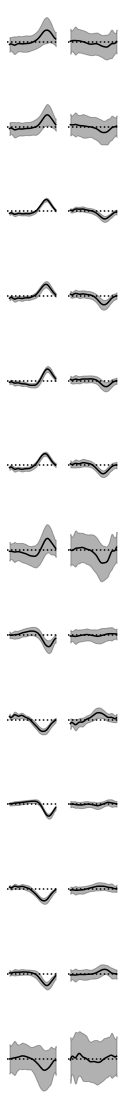

In [35]:
#another way of plotting the above
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]

range_vals = 0.025

fig, ax = plt.subplots(13, 2, figsize=(2, 20))
for i, clust in enumerate(ipl_depth_order):    
    
    
    center_mean = np.mean(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
    surround_mean = np.mean(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
    
    center_sd = np.std(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
    surround_sd = np.std(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==clust], axis=1)
    xvals = np.arange(center_mean.shape[0])
    
    
    center_max = np.amax(center_mean)
    if polarity[clust] == -1:
        center_min = np.amin(center_mean)
        center_max=-center_min
    range_y_top = center_max*3
    range_y_bottom = center_max*3
    
    
    ax[i, 0].plot(center_mean, color='k',)
    ax[i, 0].fill_between(xvals, center_mean+center_sd, center_mean-center_sd, alpha=0.3, color='k')
    ax[i, 0].axhline(color='k', linestyle='dotted')
    
    ax[i, 0].set_ylim([-range_y_bottom, range_y_top])
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_xticklabels([])
    ax[i, 0].axis('off')
    
    
    range_y_top = center_max*1.2
    range_y_bottom = center_max*1.2
    
    ax[i, 1].plot(surround_mean, color='k')
    ax[i, 1].fill_between(xvals, surround_mean+surround_sd, surround_mean-surround_sd, alpha=0.3, color='k')
    ax[i, 1].axhline(color='k', linestyle='dotted')
    ax[i, 1].set_ylim([-range_y_bottom, range_y_top])

    ax[i, 1].set_yticklabels([])
    ax[i, 1].set_xticklabels([])
    ax[i, 1].axis('off')


plt.show()

In [36]:
from scipy.optimize import curve_fit

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

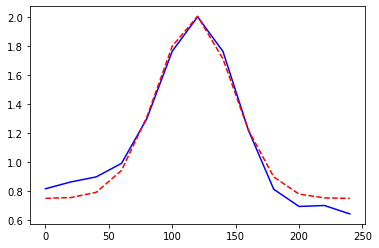

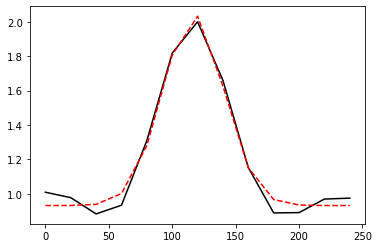

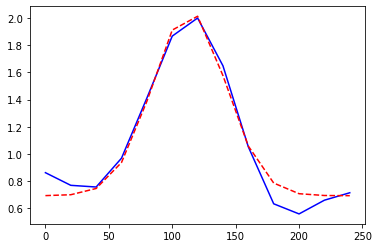

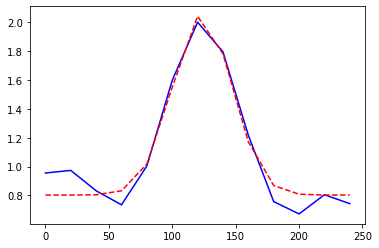

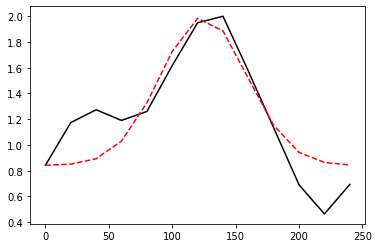

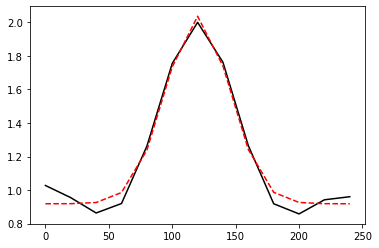

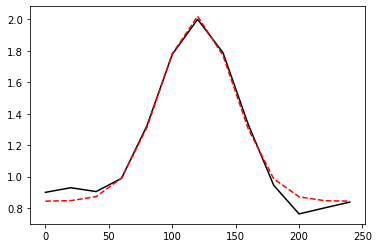

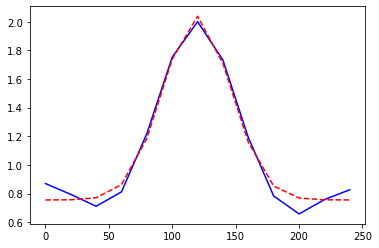

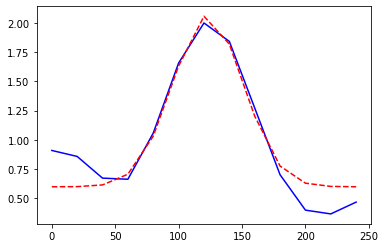

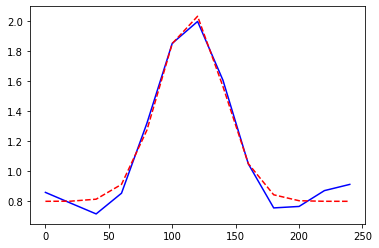

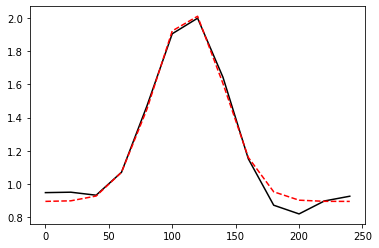

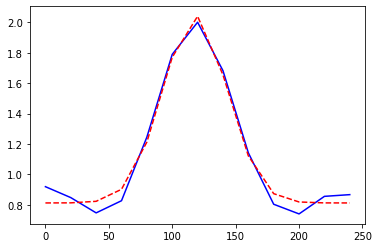

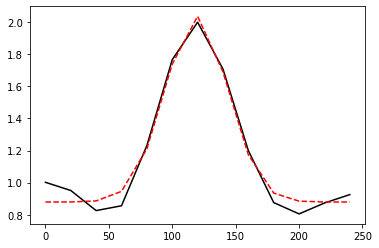

In [37]:
#calculate center FWHM by doing Gaussian Fit

center_fwhm=np.zeros(clusters.shape[0])
colors_polarity = ['black', 'red', 'blue']
for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters[225:275,13:26,i], axis=0)*polarity[i]
    space_positions = np.arange(mean_filter.shape[0])*20 #in microns
    
    
    fig = plt.figure()
    plt.plot(space_positions, mean_filter/np.amax(mean_filter)+1, color=colors_polarity[polarity[i]+1])
    

    
    H, A, x0, sigma = gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1) #adding one to get the algorithm to behave
    FWHM = 2.35482 * sigma
    center_fwhm[i] = FWHM
    
    plt.plot(space_positions, gauss(space_positions, *gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1)), '--r', label='fit')

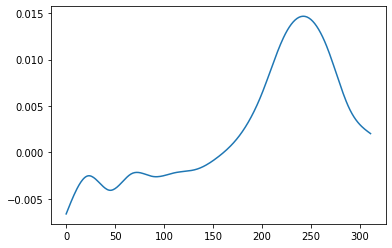

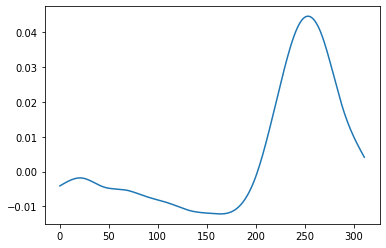

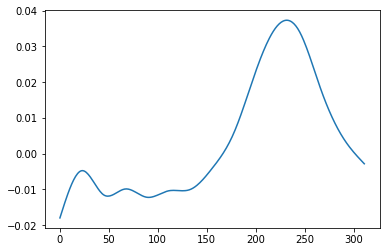

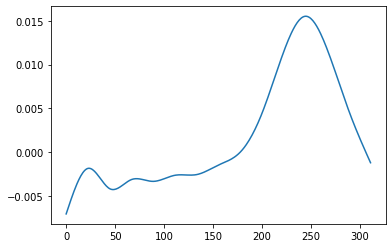

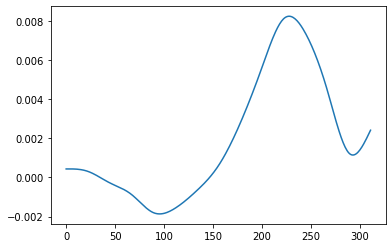

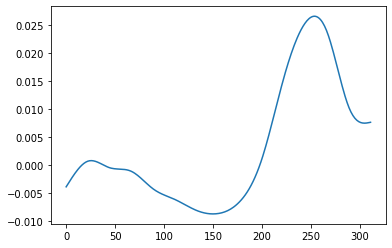

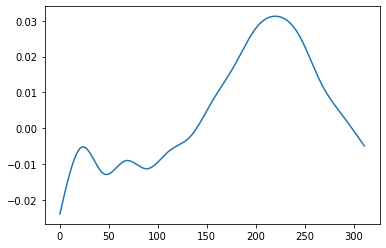

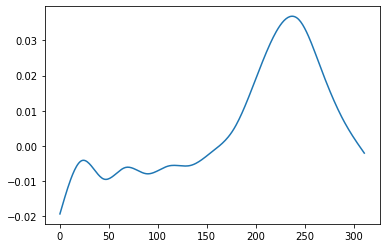

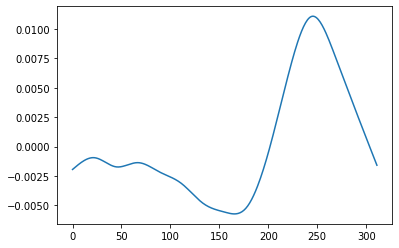

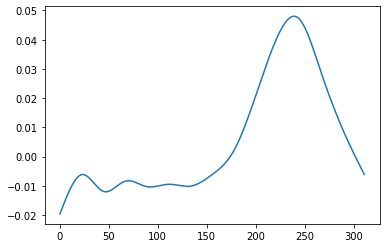

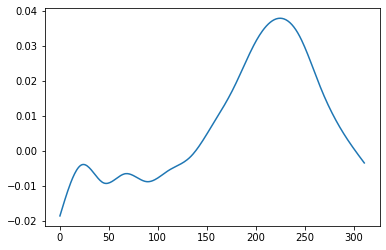

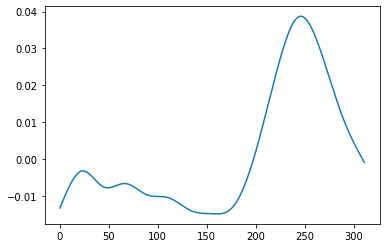

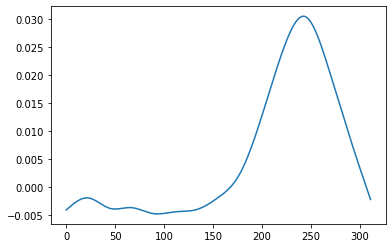

In [38]:
#calculate biphasic index

center_biphasic_index=np.zeros(clusters.shape[0])

for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters[:,18:21,i], axis=1)*polarity[i]
    
    fig = plt.figure()
    plt.plot(mean_filter)
    
    filter_max = np.amax(mean_filter)
    filter_min = np.amin(mean_filter[50:250])
    biphasic_index = filter_min/filter_max*-1
    center_biphasic_index[i] = biphasic_index

# DSI and RF features

In [39]:
def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
                             starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.

    # Moving bar is already fully on screen at t = 0
    distance_moved = distance_covered - moving_bar_length  # [um]
    stimulation_time = (distance_moved / stimulus_velocity)  # [s]

    # Convert from seconds & um to pixel
    stimulation_time_pixel = stimulation_time * temporal_conversion

    distance_moved_pixel = distance_moved * spatial_conversion
    dendrite_length_pixel = dendrite_length * spatial_conversion
    moving_bar_length_pixel = moving_bar_length * spatial_conversion
    starting_point_pixel = starting_point * spatial_conversion
    distance_covered_pixel = distance_covered * spatial_conversion

    # Slope of diagonal
    slope = -stimulation_time_pixel / distance_moved_pixel

    # Calculate thickness of diagonal
    alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
    diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

    # Calculate coordinates for beginning & end of diagonal
    # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
    x_start = starting_point_pixel
    x_stop = x_start + distance_covered_pixel

    y_start = (moving_bar_length_pixel / 2) * slope  # Negative
    y_stop = stimulation_time_pixel - y_start

    return (stimulation_time_pixel, dendrite_length_pixel,
            diagonal_thickness,
            x_start, x_stop, y_start, y_stop)

In [40]:
#pull the convolution parameters for modeling
convolution_params = {}
file = h5py.File('Data/Fig2_3_S3.hdf5', 'r')
dict_group_load = file['convolution_params']
dict_group_keys = dict_group_load.keys()
for k in dict_group_keys:
    convolution_params[k]= np.float(dict_group_load[k][0])
    
real_time_lag = convolution_params['real_time_lag']
time_points = convolution_params['time_points']
space_per_pixelx = convolution_params['space_per_pixelx']
space_per_pixely = convolution_params['space_per_pixely']


array([ 0.04691679,  0.02523501, -0.12969111, -0.29352812,  0.1014449 ,
        0.01273898, -0.24165404, -0.24664558, -0.64845295, -0.19599908,
       -0.0675668 , -0.14985009, -0.1626606 ])

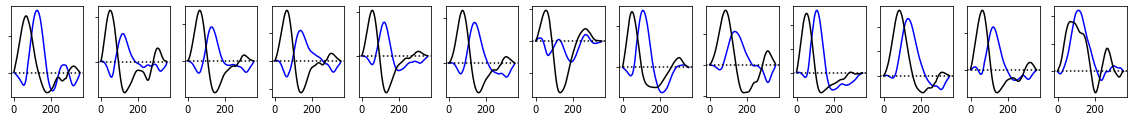

In [41]:
# Get response predictions for 1000 um/s for display

# get the stimulus for convolution




convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 140
convolution_params['distance_covered'] = 140

if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



#get convolved responses

# cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
dsi = np.zeros(13)
dsi_off = np.zeros(13)

fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:,:,clust]
    edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
    # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
    # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
    peak_y = index_max[1]
    peak_y = 19

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(response[:300])
    max_response_rev = np.amax(response_rev[:300])
    max_response_off = np.amin(response[:300])
    max_response_rev_off = np.amin(response_rev[:300])
    dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#     print(dsi, dsi_off)
#     plt.figure()
    ax[i].plot(response*polarity[clust], color='b')
    ax[i].plot(response_rev*polarity[clust], color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
#     ax[i].set_xticklabels([])
#     ax[i].axis('off')


dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
dsi_all
# Figpath = 'Fig_temp/'
# savename = Figpath+"Convolved_responses_1000um_s_half.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

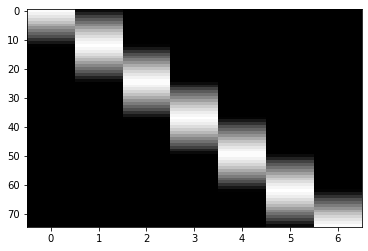

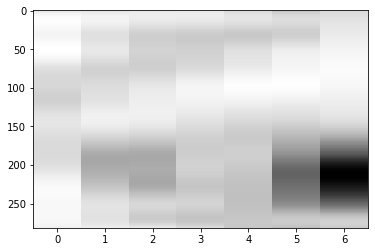

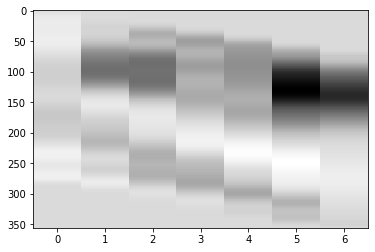

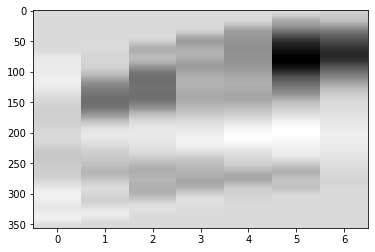

In [42]:
#checking modeling outputs

#plot of the stimulus
fig = plt.figure()
plt.imshow(stimulus_image, cmap='Greys_r', aspect='auto')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_inward_off.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

#plot of cut RF
fig = plt.figure()
plt.imshow(spline_cut, cmap='Greys_r', aspect='auto')

#plots of the convolved responses
fig = plt.figure()
plt.imshow(convolved_response, cmap='Greys_r', aspect='auto')

fig = plt.figure()
plt.imshow(convolved_response_rev, cmap='Greys_r', aspect='auto')

In [43]:
# real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')

s_per_pixel = real_time_lag/time_points

In [44]:
real_time_lag

0.4992

In [45]:
s_per_pixel

0.0015999999999999999

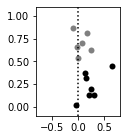

In [46]:
#plot of DSI vs. cluster average depth
fig = plt.figure(figsize=(1.5,2))

plt.scatter(dsi_all[cluster_avg_depth<0.5]*-1, cluster_avg_depth[cluster_avg_depth<0.5], color='k', linewidth=0)
plt.scatter(dsi_all[cluster_avg_depth>0.5]*-1, cluster_avg_depth[cluster_avg_depth>0.5], color='grey', linewidth=0)
# plt.scatter(dsi_off, cluster_avg_depth)
axes = plt.gca()
axes.set_xlim(-0.8,0.8)
axes.set_ylim(-0.1,1.1)
# axes.axhline(on_mean, linestyle='dotted', color='k')
# axes.axhline(off_mean, linestyle='dotted', color='k')
axes.axvline(linestyle='dotted', color='k')

# Figpath = 'Fig_temp/'
# savename = Figpath+"DSI_vs_IPLdepth.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [47]:
latency[cluster_avg_depth<0.5]*-1*s_per_pixel*1000

array([-12.8, -28.8, -41.6, -27.2, -57.6, -24. , -22.4])

(-0.7718776980548575, 0.00199335214373526)
SpearmanrResult(correlation=-0.8855248225993048, pvalue=5.6644825713402236e-05)


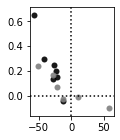

In [48]:
#plot of latency vs. DSI
fig = plt.figure(figsize=(1.5,2))

plt.scatter(latency[cluster_avg_depth<0.5]*-1*s_per_pixel*1000, dsi_all[cluster_avg_depth<0.5]*-1, alpha=0.9, color='k',linewidth=0)
plt.scatter(latency[cluster_avg_depth>0.5]*-1*s_per_pixel*1000, dsi_all[cluster_avg_depth>0.5]*-1, alpha=0.9, color='grey', linewidth=0)
axes = plt.gca()
axes.axhline(linestyle='dotted', color='k')
axes.axvline(linestyle='dotted', color='k')
# axes.set_ylim([-0.8,0.8])
# axes.set_xlim([-70,15])

#fit the line
latency_polarity_correct = list(np.concatenate((latency[cluster_avg_depth<0.5]*-1*s_per_pixel*1000, 
                                                latency[cluster_avg_depth>0.5]*-1*s_per_pixel*1000)))
# latency_polarity_correct.pop(8) #removing the outlier
dsi_polarity_correct = list(np.concatenate((dsi_all[cluster_avg_depth<0.5]*-1, 
                                            dsi_all[cluster_avg_depth>0.5]*-1)))
# dsi_polarity_correct.pop(8)
coef = np.polyfit(latency_polarity_correct,dsi_polarity_correct,1)
poly1d_fn = np.poly1d(coef) 
# plt.plot(latency_polarity_correct, poly1d_fn(latency_polarity_correct), 'b', alpha=0.4)
print(stats.pearsonr(latency_polarity_correct, dsi_polarity_correct))
print(stats.spearmanr(latency_polarity_correct, dsi_polarity_correct))


In [49]:
def make_chat_bands(layer, vmax, vmin):
    if layer == 'on':
        xvals = [vmin, vmax]
        yvals_top = [0.4, 0.4]
        yvals_bottom = [0.25, 0.25]
    else:
        xvals = [vmin, vmax]
        yvals_top = [0.8, 0.8]
        yvals_bottom = [0.65, 0.65]
    
    return xvals, yvals_top, yvals_bottom

(0.3619129546550153, 0.22431067782493497)
SpearmanrResult(correlation=0.20138103442289482, pvalue=0.5094205880071835)


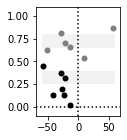

In [50]:
#plot of latency vs. IPL depth
fig = plt.figure(figsize=(1.5,2))

#make chat bands
xvals, ytop, ybottom = make_chat_bands('on', -60, 60)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.05, linewidth=0)

xvals, ytop, ybottom = make_chat_bands('off', -60, 60)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.05, linewidth=0)

plt.scatter(latency[cluster_avg_depth<0.5]*-1*s_per_pixel*1000, cluster_avg_depth[cluster_avg_depth<0.5], alpha=1, color='k', linewidth=0)
plt.scatter(latency[cluster_avg_depth>0.5]*-1*s_per_pixel*1000, cluster_avg_depth[cluster_avg_depth>0.5], alpha=1, color='grey', linewidth=0)
axes = plt.gca()
axes.axhline(linestyle='dotted', color='k')
axes.axvline(linestyle='dotted', color='k')
axes.set_ylim([-0.1,1.1])
# axes.set_xlim([-70,15])


cluster_avg_depth_polaritycorrect = list(np.concatenate((cluster_avg_depth[cluster_avg_depth<0.5], 
                                            cluster_avg_depth[cluster_avg_depth>0.5])))
print(stats.pearsonr(cluster_avg_depth_polaritycorrect, latency_polarity_correct))
print(stats.spearmanr(cluster_avg_depth_polaritycorrect, latency_polarity_correct))


(0.8540666635336768, 0.00020216995772928266)
SpearmanrResult(correlation=0.7197802197802198, pvalue=0.005536115775787642)


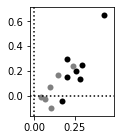

In [51]:
# plot of surround strength vs dsi
fig = plt.figure(figsize=(1.5,2))

plt.scatter(surround_strength[cluster_avg_depth<0.5]*-1, dsi[cluster_avg_depth<0.5]*-1, alpha=1, color='k', linewidth=0)
plt.scatter(surround_strength[cluster_avg_depth>0.5]*-1, dsi_off[cluster_avg_depth>0.5]*-1, alpha=1, color='grey', linewidth=0)
axes = plt.gca()
axes.axhline(linestyle='dotted', color='k')
axes.axvline(linestyle='dotted', color='k')
# axes.set_ylim([-0.4,0.4])
# axes.set_xlim([-40,10])


#fit the line
surround_strength_polarity_correct = list(np.concatenate((surround_strength[cluster_avg_depth<0.5]*-1, 
                                                surround_strength[cluster_avg_depth>0.5]*-1)))

print(stats.pearsonr(surround_strength_polarity_correct, dsi_polarity_correct))
print(stats.spearmanr(surround_strength_polarity_correct, dsi_polarity_correct))



(-0.4322352217933758, 0.14020154289753048)
SpearmanrResult(correlation=-0.4835164835164835, pvalue=0.0941346925969393)


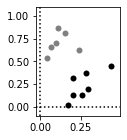

In [52]:
#plot of surround strength vs. IPL depth
fig = plt.figure(figsize=(1.5,2))

plt.scatter(surround_strength[cluster_avg_depth<0.5]*-1, cluster_avg_depth[cluster_avg_depth<0.5], alpha=1, color='k', linewidth=0)
plt.scatter(surround_strength[cluster_avg_depth>0.5]*-1, cluster_avg_depth[cluster_avg_depth>0.5], alpha=1, color='grey', linewidth=0)
axes = plt.gca()
axes.axhline(linestyle='dotted', color='k')
axes.axvline(linestyle='dotted', color='k')
axes.set_ylim([-0.1,1.1])
# axes.set_xlim([-70,15])

print(stats.pearsonr(cluster_avg_depth_polaritycorrect, surround_strength_polarity_correct))
print(stats.spearmanr(cluster_avg_depth_polaritycorrect, surround_strength_polarity_correct))



(-0.2606642309766522, 0.38970424811231136)
SpearmanrResult(correlation=-0.32417582417582413, pvalue=0.2798818688931399)


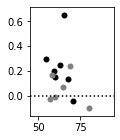

In [53]:
# FWHM vs. DSI
fig = plt.figure(figsize=(1.5,2))

plt.scatter(center_fwhm[cluster_avg_depth<0.5], dsi[cluster_avg_depth<0.5]*-1, alpha=1, color='k', linewidth=0)
plt.scatter(center_fwhm[cluster_avg_depth>0.5], dsi_off[cluster_avg_depth>0.5]*-1, alpha=1, color='grey', linewidth=0)
axes = plt.gca()
axes.axhline(linestyle='dotted', color='k')
# axes.axvline(linestyle='dotted', color='k')
# axes.set_ylim([-0.4,0.4])
axes.set_xlim([45,95])

#fit the line
center_fwhm_polarity_correct = list(np.concatenate((center_fwhm[cluster_avg_depth<0.5], 
                                                center_fwhm[cluster_avg_depth>0.5])))

print(stats.pearsonr(center_fwhm_polarity_correct, dsi_polarity_correct))
print(stats.spearmanr(center_fwhm_polarity_correct, dsi_polarity_correct))


(0.6231398024572844, 0.0228911317915561)
SpearmanrResult(correlation=0.38461538461538464, pvalue=0.19441291997748622)


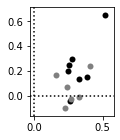

In [54]:
# Biphasic index vs. DSI
fig = plt.figure(figsize=(1.5,2))

plt.scatter(center_biphasic_index[cluster_avg_depth<0.5], dsi[cluster_avg_depth<0.5]*-1, alpha=1, color='k', linewidth=0)
plt.scatter(center_biphasic_index[cluster_avg_depth>0.5], dsi_off[cluster_avg_depth>0.5]*-1, alpha=1, color='grey', linewidth=0)
axes = plt.gca()
axes.axhline(linestyle='dotted', color='k')
axes.axvline(linestyle='dotted', color='k')
# axes.set_ylim([-0.4,0.4])
# axes.set_xlim([-40,10])


#fit the line
center_biphasic_index_polarity_correct = list(np.concatenate((center_biphasic_index[cluster_avg_depth<0.5], 
                                                center_biphasic_index[cluster_avg_depth>0.5])))

print(stats.pearsonr(center_biphasic_index_polarity_correct, dsi_polarity_correct))
print(stats.spearmanr(center_biphasic_index_polarity_correct, dsi_polarity_correct))



(0.26266470232638356, 0.3859432689881185)
SpearmanrResult(correlation=0.13736263736263735, pvalue=0.6545168402947126)


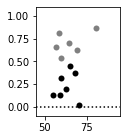

In [55]:
# FWHM vs. IPL depth
fig = plt.figure(figsize=(1.5,2))

plt.scatter(center_fwhm[cluster_avg_depth<0.5], cluster_avg_depth[cluster_avg_depth<0.5], alpha=1, color='k', linewidth=0)
plt.scatter(center_fwhm[cluster_avg_depth>0.5], cluster_avg_depth[cluster_avg_depth>0.5], alpha=1, color='grey', linewidth=0)
axes = plt.gca()
axes.axhline(linestyle='dotted', color='k')
# axes.axvline(linestyle='dotted', color='k')
axes.set_ylim([-0.1,1.1])
axes.set_xlim([45,95])
# axes.set_xlim([-70,15])


print(stats.pearsonr(cluster_avg_depth_polaritycorrect, center_fwhm_polarity_correct))
print(stats.spearmanr(cluster_avg_depth_polaritycorrect, center_fwhm_polarity_correct))



(-0.13744907460450934, 0.6543116157586742)
SpearmanrResult(correlation=-0.30769230769230765, pvalue=0.3064470525125291)


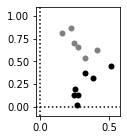

In [56]:
# biphasic index vs. ipl depth
fig = plt.figure(figsize=(1.5,2))

plt.scatter(center_biphasic_index[cluster_avg_depth<0.5], cluster_avg_depth[cluster_avg_depth<0.5], alpha=1, color='k', linewidth=0)
plt.scatter(center_biphasic_index[cluster_avg_depth>0.5], cluster_avg_depth[cluster_avg_depth>0.5], alpha=1, color='grey', linewidth=0)
axes = plt.gca()
axes.axhline(linestyle='dotted', color='k')
axes.axvline(linestyle='dotted', color='k')
axes.set_ylim([-0.1,1.1])
# axes.set_xlim([45,95])
# axes.set_xlim([-70,15])


print(stats.pearsonr(cluster_avg_depth_polaritycorrect, center_biphasic_index_polarity_correct))
print(stats.spearmanr(cluster_avg_depth_polaritycorrect, center_biphasic_index_polarity_correct))



In [57]:
# #convolution across whole RF, one velocity

# convolution_stim_params_id = 'convolution_stim_params_id = 2'
# # field = field3

# convolution_params_other = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()

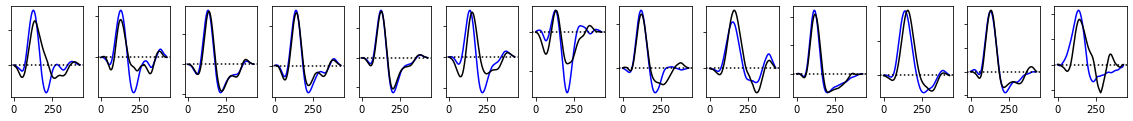

In [58]:
convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 260
convolution_params['distance_covered'] = 260
# real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
# space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))


#get convolved responses

# cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
dsi = np.zeros(13)
dsi_off = np.zeros(13)

fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:, 13:26, clust] #average_filters[:,4:24,clust]
    edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
    # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
    # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
    peak_y = index_max[1]
    peak_y = 19

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(response[:300])
    max_response_rev = np.amax(response_rev[:300])
    max_response_off = np.amin(response[:300])
    max_response_rev_off = np.amin(response_rev[:300])
    dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#     print(dsi, dsi_off)
#     plt.figure()
    ax[i].plot(response*polarity[clust], color='b')
    ax[i].plot(response_rev*polarity[clust], color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
#     ax[i].set_xticklabels([])
#     ax[i].axis('off')


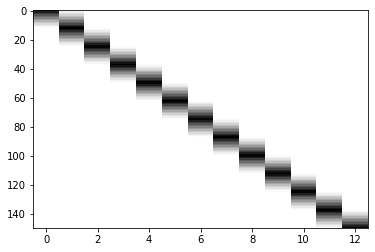

In [59]:
#stimulus image
plt.imshow(stimulus_image*-1, cmap='Greys_r', aspect='auto')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_full_off.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

# Velocity tuning

In [60]:
def convolved_dsis(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,:,clust] #average_filters_mirror[:, :, clust] 4:24
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
#         print(peak_y)
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

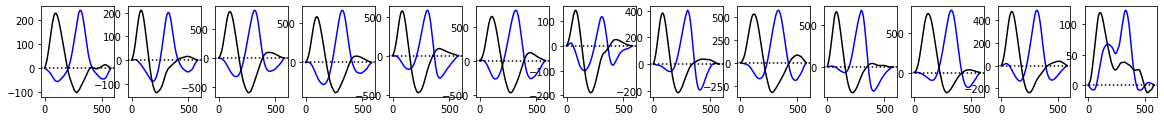

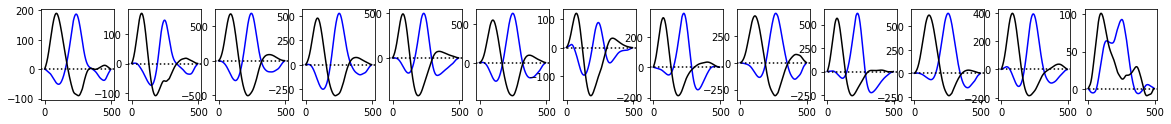

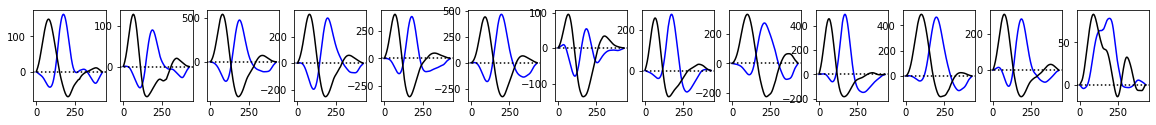

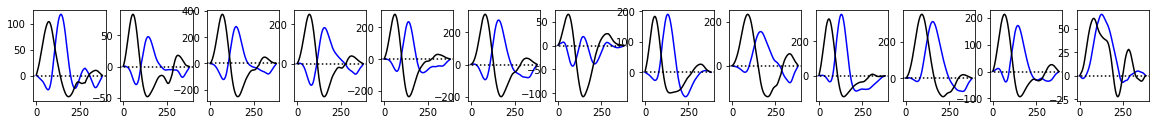

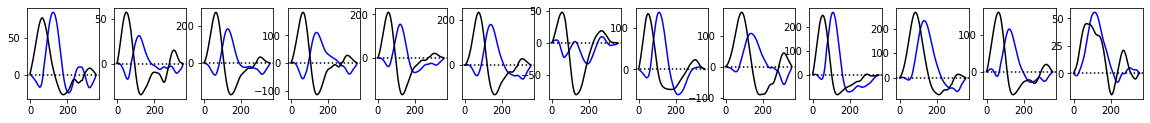

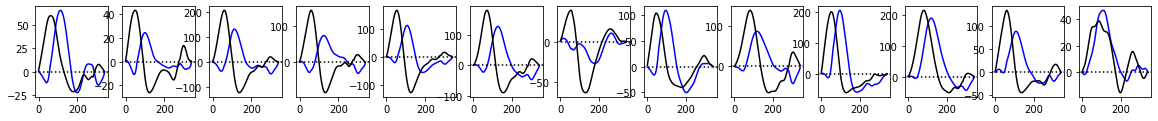

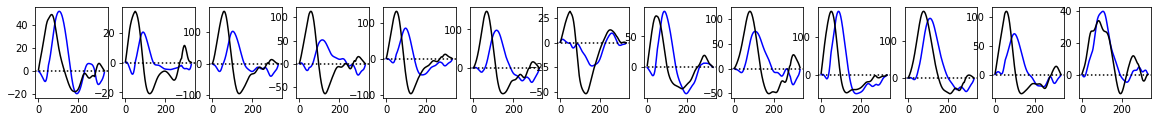

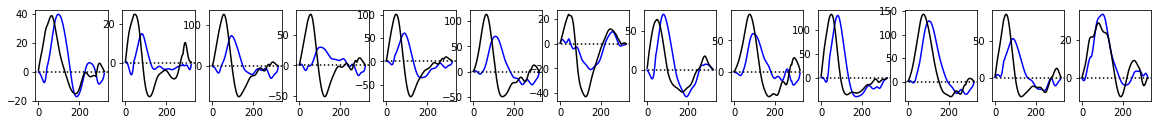

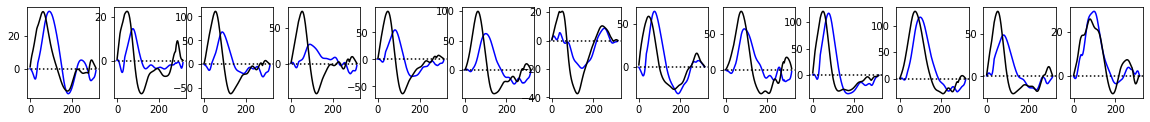

In [61]:
#run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis(velocity, convolution_params)
    dsi_all_all[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

In [62]:
dsi_all_all_for_roimasks = dsi_all_all

In [63]:
def convolved_dsis_centered(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 180 #av updated in revision 2
    convolution_params['distance_covered'] = 180
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,15:24,clust]
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          4:11]
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2 +1)]
#             print(kernel_length)
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].axis('off')
#         if velocity == 1000:
#             Figpath = 'Fig_temp/'
#             savename = Figpath+"Convolved_responses_1000.pdf"
#             plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

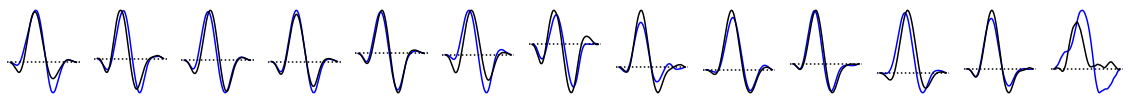

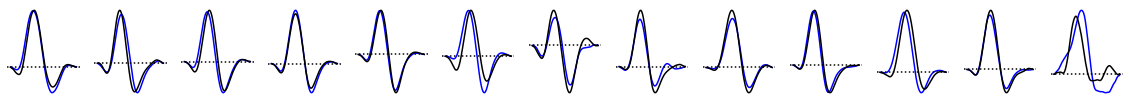

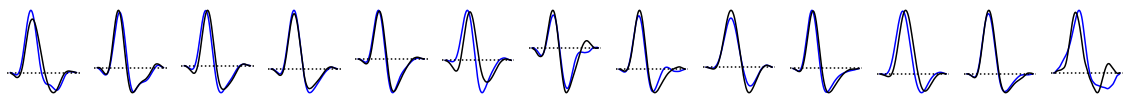

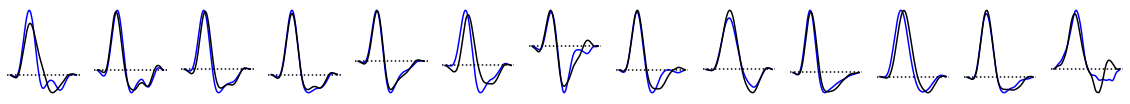

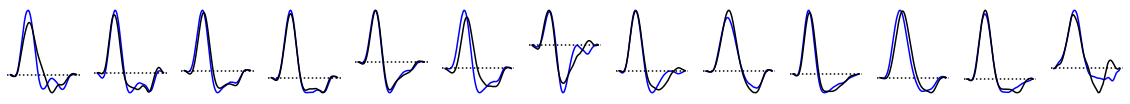

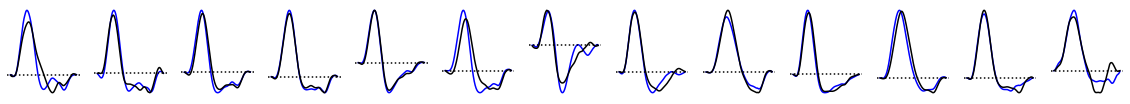

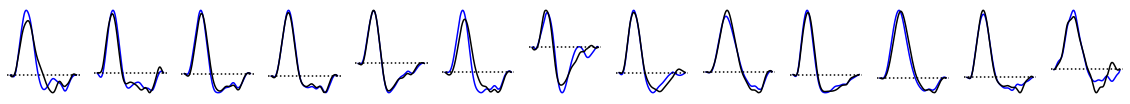

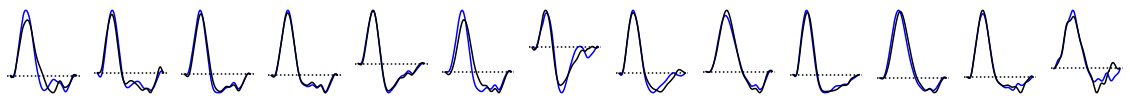

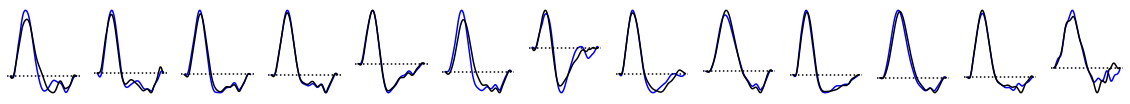

In [64]:
# run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_centered = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_centered(velocity, convolution_params)
    dsi_all_all_centered[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

In [65]:
def convolved_dsis_RIGHT(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
#     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,:,clust] #average_filters_mirror[:, :, clust] 4:24
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'right'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
#         print(peak_y)
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

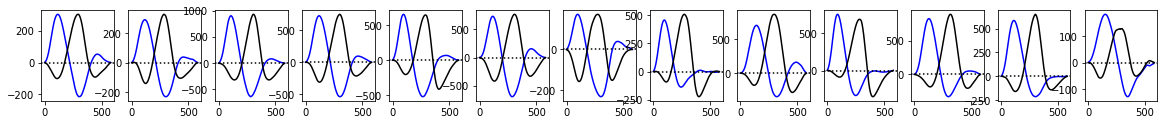

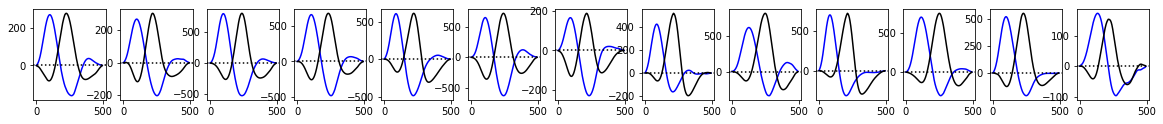

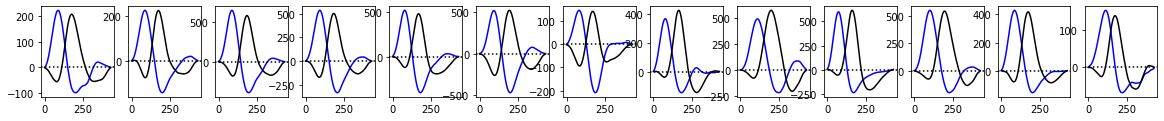

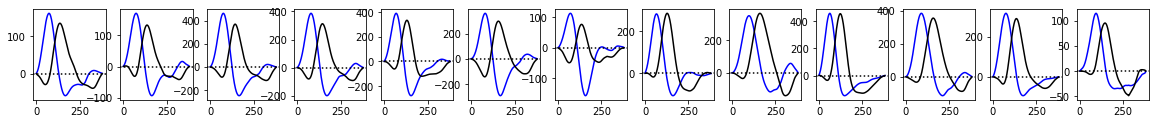

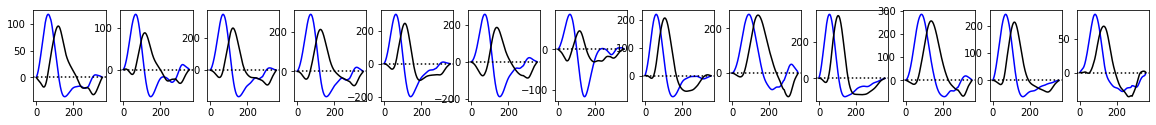

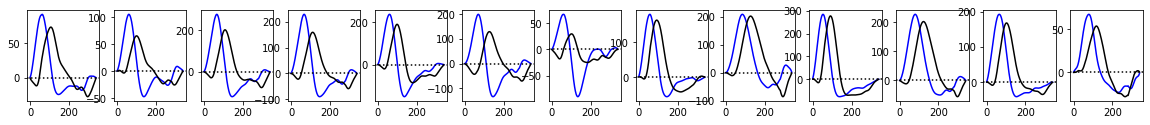

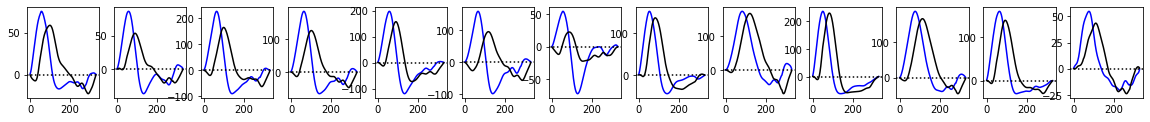

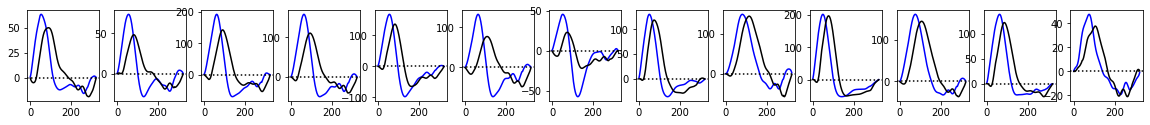

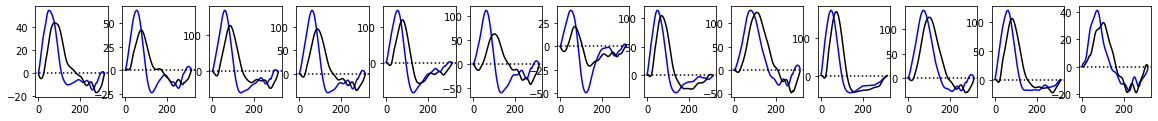

In [66]:
#run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_right = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_RIGHT(velocity, convolution_params)
    dsi_all_all_right[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

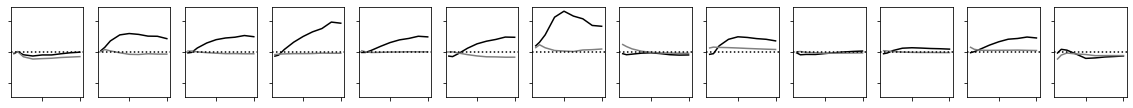

In [67]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_centered[:, clust]*-1, color='grey')
#     ax[i].plot(velocities, dsi_all_all_right[:, clust], color='r')
    ax[i].set_ylim([-.72, .72])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()


# Figpath = 'Fig_temp/'
# savename = Figpath+"Velocity_tuning_clusters_both.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
# plt.show()

In [68]:
# def convolved_dsis_centered(velocity, convolution_params):
#     # velocity tuning

#     # get the stimulus for convolution

# #     convolution_stim_params_id = 'convolution_stim_params_id = 1'
# #     field = field3

# #     convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
#     convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
#     convolution_params['dendrite_length'] = 180 #av updated in revision 2
#     convolution_params['distance_covered'] = 180
# #     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
# #     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
#     if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
#         space_per_pixel = space_per_pixelx
#     else:
#         space_per_pixel = space_per_pixely

#     time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
#         convolution_params['dendrite_length'],
#         convolution_params['moving_bar_length'],
#         convolution_params['stimulus_velocity'],
#         convolution_params['starting_point'],
#         convolution_params['distance_covered'],
#         real_time_lag,
#         time_points,
#         space_per_pixel
#     )

#     string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
#         <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
#           <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
#               stroke-width="{10}" stroke="white" stroke-linecap="square"/>
#         </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

#     folder_str = 'Data/'
#     file_name = str(1)
#     name_svg = folder_str + file_name + ".svg"
#     name_png = folder_str + file_name + ".png"

#     new_file = open(name_svg, "wt")
#     new_file.write(string_svg)
#     new_file.close()

#     cairosvg.svg2png(url=name_svg, write_to=name_png)

#     stimulus_image = np.array(Image.open(name_png).convert('L'))
#     plt.imshow(stimulus_image,cmap='Greys', aspect='auto')
# #     Figpath = 'Fig_temp/'
# #     savename = Figpath+"New_Stim_Full_off.pdf"
# #     plt.savefig(savename, transparent=True, bbox_inches='tight')

#     #get convolved responses

# #     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
#     dsi = np.zeros(13)
#     dsi_off = np.zeros(13)

#     fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
#     for i, clust in enumerate(ipl_depth_order):
#         # get the necessaries
#         # spline = (NoiseSplineRF2 & key).fetch1('spl')
#         spline = average_filters[:,15:24,clust]
#         edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
#         # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
#         stimulus_image_rev = np.flip(stimulus_image, axis=0)
#         kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
#         # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

#         # set up and crop the kernel
#         kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

#         # get the location of the RF center in the kernel
#         spline_temp = spline[edge_buffer:-edge_buffer, :]
#         index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
#         peak_y = index_max[1]
#         peak_y = 19

#         # crop the kernel depending on the type of experiment
#         if kernel_type == 'right':
#             spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
#         elif kernel_type == 'left':
#             spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
#         elif kernel_type == 'full':
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          0:kernel_length]  # should be full kernel, just adding space range just in case
#         elif kernel_type == 'centered':
# #             spline_cut = spline[edge_buffer:-edge_buffer,
# #                          4:11]
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2 +1)]
# #             print(kernel_length)
#         else:
#             spline_cut = spline  # just to make the code happy, this should never be the option
#         # can code in other possibilities here...

#         # check whether cut spline is big enough
#         space_length = spline_cut.shape[1]
#         if kernel_length == space_length:
#             empty_flag = 0
#             # setup output variables
#             convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
#             convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

#             # loop through x positions and convolve
#             for x_position in range(stimulus_image.shape[1]):
#                 ker = np.flip(spline_cut[:, x_position])
#                 img = stimulus_image[:, x_position]
#                 img2 = stimulus_image_rev[:, x_position]
#                 # and then convolve these two
#                 convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
#                 convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
#         else:
#             empty_flag = 1
#             convolved_response = []
#             convolved_response_rev = []

#         response = np.sum(convolved_response, axis=1)
#         response_rev = np.sum(convolved_response_rev, axis=1)
#         max_response = np.amax(response)
#         max_response_rev = np.amax(response_rev)
#         max_response_off = np.amin(response)
#         max_response_rev_off = np.amin(response_rev)
#         dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
# #         print(max_response, max_response_rev)
#         dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
# #         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
#     #     print(dsi, dsi_off)
#     #     plt.figure()
# #         ax[i].plot(response*polarity[clust], color='b')
# #         ax[i].plot(response_rev*polarity[clust], color='k')
# #         ax[i].axhline(color='k', linestyle='dotted')
# #         ax[i].set_yticklabels([])
# #         ax[i].set_xticklabels([])
# #         ax[i].axis('off')
# #         if velocity == 1000:
# #             ax[i].imshow(spline_cut, aspect='auto', cmap='Greys_r')
# #             Figpath = 'Fig_temp/'
# #             savename = Figpath+"Spines_for_Full.pdf"
# #             plt.savefig(savename, transparent=True, bbox_inches='tight')
#     return dsi, dsi_off

# # get the images
# velocities = [1000]

# dsi_all_all_centered = np.zeros((len(velocities), 13))

# for i, velocity in enumerate(velocities):
#     dsi, dsi_off = convolved_dsis_centered(velocity, convolution_params)
#     dsi_all_all_centered[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

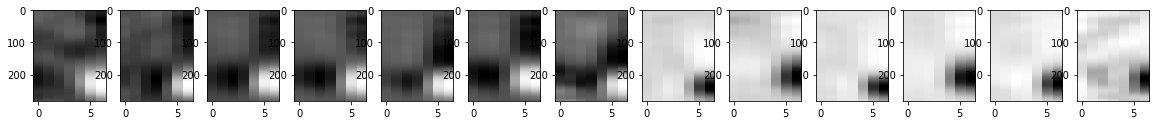

In [69]:
#plotting image of cropped RF

def convolved_dsis(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

#     convolution_stim_params_id = 'convolution_stim_params_id = 1'
#     field = field3

#     convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
#     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

#     fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))

    if velocity == 1000:
        fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,:,clust]
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
#         ax[i].plot(response*polarity[clust], color='b')
#         ax[i].plot(response_rev*polarity[clust], color='k')
#         ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')
        if velocity == 1000:


            ax[i].imshow(spline_cut, aspect='auto', cmap='Greys_r')
#             Figpath = 'Fig_temp/'
#             savename = Figpath+"Spines_for_Half.pdf"
#             plt.savefig(savename, transparent=True, bbox_inches='tight')
#             ax[i].set_yticklabels([])
#             ax[i].set_xticklabels([])
#             ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

velocities = [1000,]

dsi_all_all = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis(velocity, convolution_params)
    dsi_all_all[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

# Mapping parameters onto field positions

In [70]:
def get_cluster_map(field_num, df_column):
#     roimask = (Field.RoiMask() & field).fetch1('roi_mask')
    
    #pull from hdf5 file
    #read hdf5 file for this notebook
    f1 = h5py.File("Data/Fig2_3_S3.hdf5", "r")
    #get the data for plotting the sd image
    roimask_name = 'field'+str(field_nums[i])+'_roimask'
    roimask = np.array(f1[roimask_name])
    f1.close()
    
    roi_clusters = s_df_xz_masked.loc[s_df_xz_masked['field'] == field_num, df_column] 

    roi_list = np.array(roi_clusters.index.to_frame(index=False))[:,0]

    #make map
    clustermap0 = roimask*(-1)
    xlength = clustermap0.shape[0]
    ylength = clustermap0.shape[1]
    for x in range(xlength):
        for y in range(ylength):  
            if clustermap0[x,y] in roi_list:
                roi_index = np.int(clustermap0[x, y])
                clustermap0[x,y] = roi_clusters.loc[roi_index]
            else:
                clustermap0[x,y] = np.nan
    return clustermap0

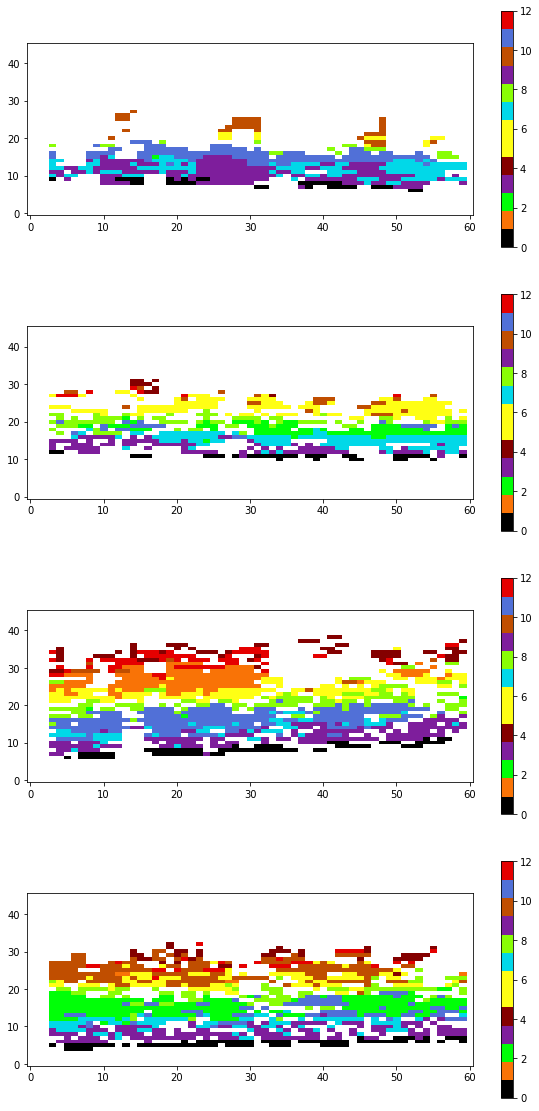

In [71]:
# cluster assignment onto fields

n_bins = 13
# current_palette = sns.color_palette('BrBG') #for DSI
# current_palette = sns.color_palette('rocket') #for latency
 
current_palette = sns.xkcd_palette(['black', 'orange', 'bright green', 'purple', 'dark red', 'yellow', 'yellow', 
                                   'aqua blue', 'lime green', 'purple', 'burnt orange', 'cornflower blue', 'red'])
# current_palette = sns.color_palette('colorblind')

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

fig = plt.figure(figsize=(10, 20))
# fields = [field3, field6, field7, field13]
field_nums = [3, 6, 7, 13]


for i, field in enumerate(field_nums):
    clustermap = get_cluster_map(field, 'new_cluster_assignment')
    

    ax0 = fig.add_subplot(4,1,i+1)
    plt.imshow(clustermap.T[10:, 3:], aspect=1/aspect, origin='lower', cmap=cm, vmin=0, vmax=12)#, origin='lower') 
    plt.colorbar()

# Figpath = 'Fig_temp/'
# savename = Figpath+"Fields_clusters.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

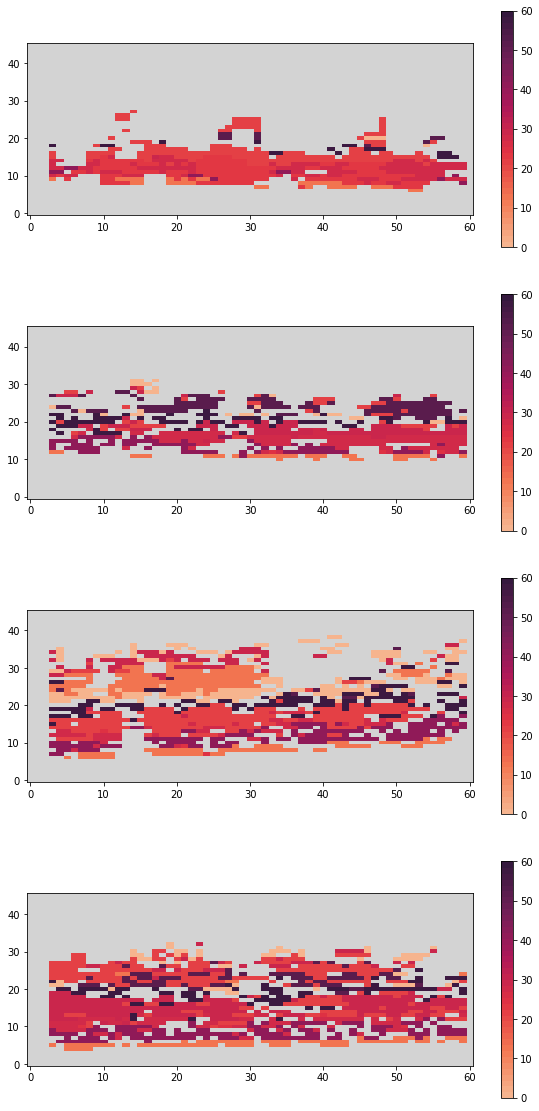

In [72]:
# latency mapped onto fields
s_df_xz_masked['latency_ms'] = s_df_xz_masked['new_cluster_assignment'].replace(
    original_clusters, latency*-1*s_per_pixel*1000)

n_bins = 40
# current_palette = sns.color_palette('BrBG') #for DSI
current_palette = sns.color_palette('rocket_r') #for latency
# current_palette = sns.color_palette('colorblind')

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)
cm.set_bad(color='lightgrey')
fig = plt.figure(figsize=(10, 20))
# fields = [field3, field6, field7, field13]
field_nums = [3, 6, 7, 13]


for i, field in enumerate(field_nums):
    clustermap = get_cluster_map(field, 'latency_ms')
    

    ax0 = fig.add_subplot(4,1,i+1)
    plt.imshow(clustermap.T[10:, 3:]*-1, aspect=1/aspect, origin='lower', cmap=cm, vmin=0, vmax=60)#, origin='lower') 
    plt.colorbar()

# Figpath = 'Fig_temp/'
# savename = Figpath+"Fields_latency.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

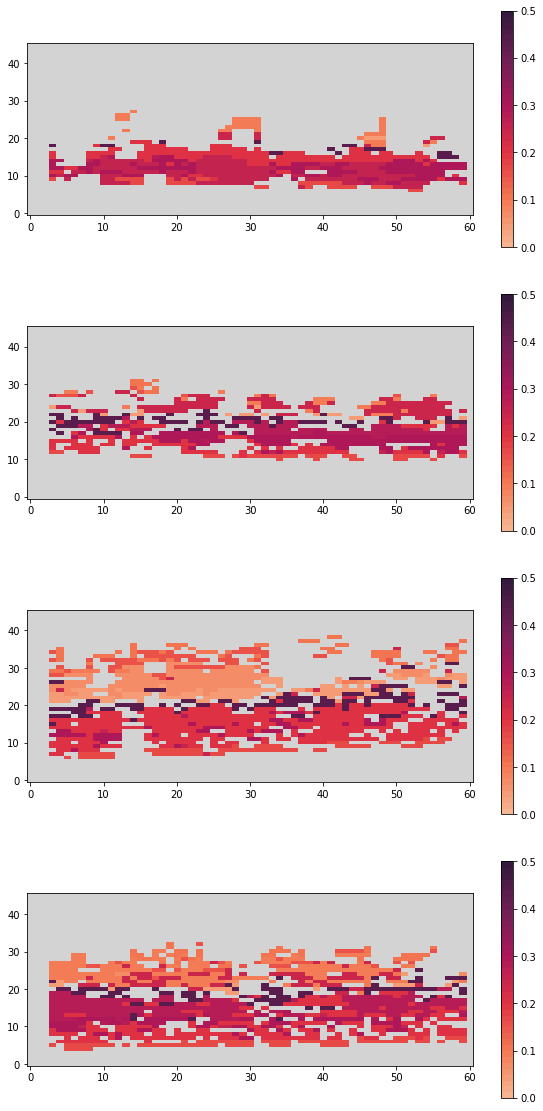

In [73]:
#surround strength mapped onto fields
s_df_xz_masked['surround_strength'] = s_df_xz_masked['new_cluster_assignment'].replace(
    original_clusters, surround_strength*-1)

n_bins = 40
# current_palette = sns.color_palette('BrBG') #for DSI
current_palette = sns.color_palette('rocket_r') #for latency
# current_palette = sns.color_palette('colorblind')

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)
cm.set_bad(color='lightgrey')
fig = plt.figure(figsize=(10, 20))
# fields = [field3, field6, field7, field13]
field_nums = [3, 6, 7, 13]


for i, field in enumerate(field_nums):
    clustermap = get_cluster_map(field, 'surround_strength')
    

    ax0 = fig.add_subplot(4,1,i+1)
    plt.imshow(clustermap.T[10:, 3:], aspect=1/aspect, origin='lower', cmap=cm, vmin=0, vmax=0.5)#, origin='lower') 
    plt.colorbar()

# Figpath = 'Fig_temp/'
# savename = Figpath+"Fields_surround_strength.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

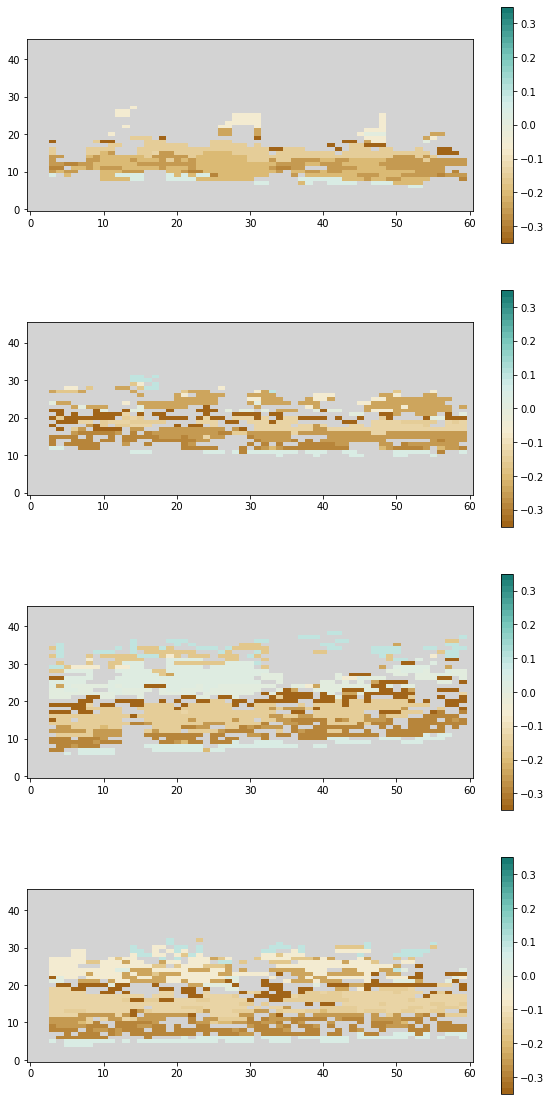

In [74]:
#DSI mapped onto fields
s_df_xz_masked['dsi_1000um_s'] = s_df_xz_masked['new_cluster_assignment'].replace(
    original_clusters, dsi_all_all_for_roimasks[4,:]) #1000 um/s

n_bins = 40
current_palette = sns.color_palette('BrBG') #for DSI
# current_palette = sns.color_palette('rocket') #for latency
# current_palette = sns.color_palette('colorblind')

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)
cm.set_bad(color='lightgrey')

fig = plt.figure(figsize=(10, 20))
# fields = [field3, field6, field7, field13]
field_nums = [3, 6, 7, 13]


for i, field in enumerate(field_nums):
    clustermap = get_cluster_map(field, 'dsi_1000um_s')
    

    ax0 = fig.add_subplot(4,1,i+1)
    plt.imshow(clustermap.T[10:, 3:], aspect=1/aspect, origin='lower',
               cmap=cm, vmin=-0.35, vmax=0.35)#, origin='lower') 
    plt.colorbar()

# Figpath = 'Fig_temp/'
# savename = Figpath+"Fields_dsiall.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

# Correlating with EM stratifications

In [75]:
#load EM stratification data
EM_stratification = np.loadtxt('Data/BC_Profiles_Helmstaedter.txt')

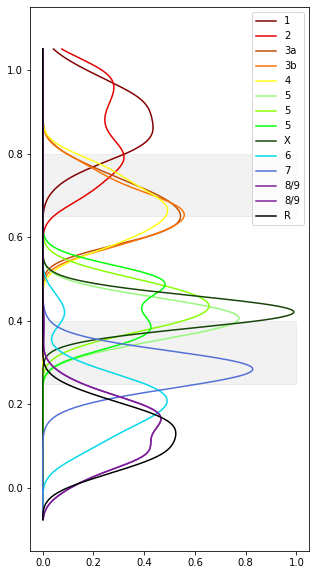

In [76]:
#plot EM stratification
fig = plt.figure(figsize=(5,10))

#make chat bands
xvals, ytop, ybottom = make_chat_bands('on', 0, 1)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.05)

xvals, ytop, ybottom = make_chat_bands('off', 0, 1)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.05)


#plot the bc stratification
bc_names = ['1', '2', '3a', '3b', '4', '5', '5', '5', 'X', '6', '7', '8/9', '8/9', 'R']
colors = ['xkcd:dark red', 'xkcd:red', 'xkcd:burnt orange', 
          'xkcd:orange', 'xkcd:yellow', 'xkcd:light green', 
          'xkcd:lime green', 'xkcd:bright green', 
          'xkcd:forrest green', 'xkcd:aqua blue', 
          'xkcd:cornflower blue', 'xkcd:purple', 'xkcd:purple', 'xkcd:black']
start = -2.3
stop = 2.2
range_vals = stop-start
x_vals = np.linspace(start, stop, num=400, endpoint=True)
x_vals = (x_vals - (-2))/(range_vals-.5)

for i, bc_name in enumerate(bc_names):
    plt.plot(EM_stratification[:, i]*10/0.3, x_vals, color=colors[i], label=bc_name)

plt.legend()



axes = plt.gca()
axes.set_ylim([-0.15, 1.15])


# Figpath = 'Fig_temp/'
# savename = Figpath+"EM_stratification.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

In [77]:
#calculate KDE for clusters

clusters_kde = np.zeros((400, clusters.shape[0]))

for i, clust in enumerate(ipl_depth_order):
# for i in range(clusters.shape[0]):
    to_kde = s_df_xz_masked.loc[
        s_df_xz_masked['new_cluster_assignment'] == clust, 'depth']
    positions=np.linspace(-.1, 1.1, num=400)

    kernel = stats.gaussian_kde(to_kde)
    Z = kernel(positions)
    
    clusters_kde[:, i] = Z

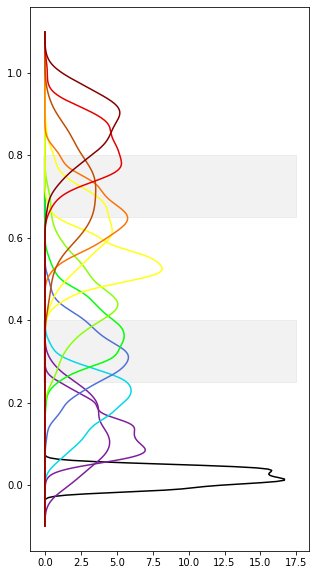

In [78]:
#Plot cluster stratification
colors = ['xkcd:dark red', 'xkcd:red', 'xkcd:burnt orange', 
          'xkcd:orange', 'xkcd:yellow', 'xkcd:yellow', 
          'xkcd:lime green', 'xkcd:bright green', 'xkcd:cornflower blue',
           'xkcd:aqua blue', 
           'xkcd:purple', 'xkcd:purple', 'xkcd:black']

fig = plt.figure(figsize=(5,10))

#make chat bands
xvals, ytop, ybottom = make_chat_bands('on', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.05)

xvals, ytop, ybottom = make_chat_bands('off', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.05)

for i in range(13):

    plt.plot(clusters_kde[:, i], positions, color=colors[12-i])


# axes = plt.gca()
# axes.set_ylim([-0.15, 1.15])
    
# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_stratification.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
plt.show()

In [79]:
ipl_depth_order


Int64Index([0, 3, 9, 7, 11, 2, 8, 5, 6, 1, 10, 12, 4], dtype='int64', name='new_cluster_assignment')

In [80]:
# calculate correlation between EM and clusters
bc_names = ['1', '2', '3a', '3b', '4', '5', '5', '5', 'X', '6', '7', '8/9', '8/9b', 'R']
cluster_names = [str(x) for x in ipl_depth_order]

columns = cluster_names + bc_names
correlation_frame = pd.DataFrame(data=np.concatenate((clusters_kde, EM_stratification), axis=1), columns=columns).corr()

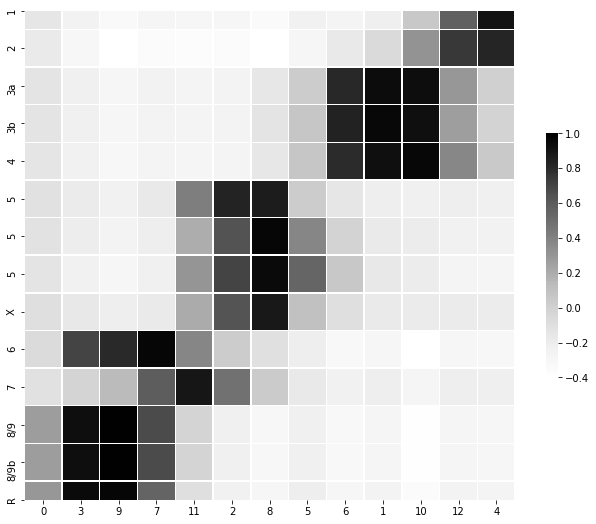

In [81]:
#plot correlation matrix
corr_matrix = correlation_frame.iloc[13:,0:13]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='Greys', 
            square=False, linewidths=.5, cbar_kws={"shrink": .5}, 
           yticklabels=bc_names, xticklabels=cluster_names,vmax=1, vmin=-.4) #, mask=mask #center=0, vmax=1, vmin=-.2

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_correlation.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

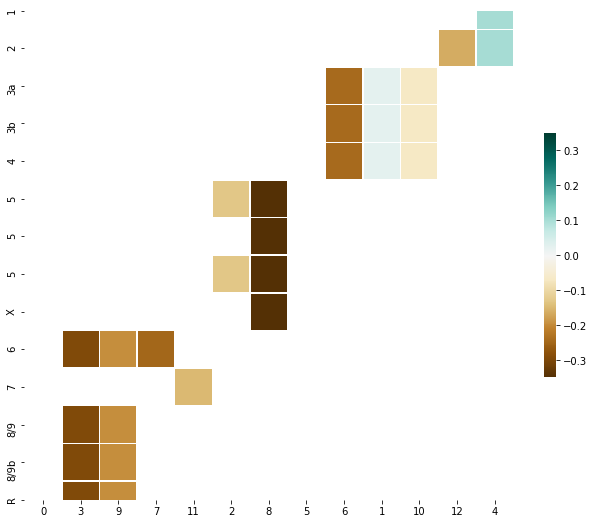

In [82]:
# apply a threshold and map DSIs onto above threshold squares

threshold = 0.70
corr_matrix = np.where(correlation_frame.iloc[13:,0:13]>threshold, 1, np.nan)*dsi_all_all_for_roimasks[4,ipl_depth_order]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='BrBG', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, center=0,
           yticklabels=bc_names, xticklabels=cluster_names, vmax=0.35, vmin=-0.35) #, mask=mask

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_DSI.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [83]:
# function for mapping parameter values onto stratification depth with calculated kde plots

from matplotlib.collections import LineCollection

def multiline(xs, ys, c, vmin, vmax, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))
    lc.set_clim(vmin=vmin, vmax=vmax)

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

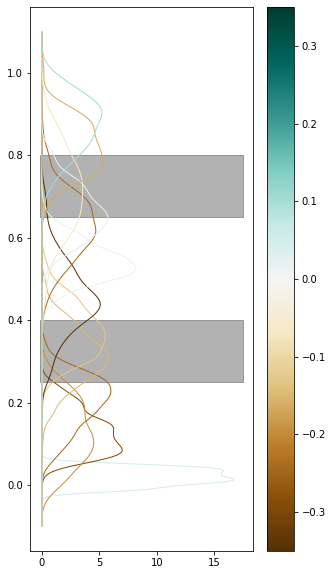

In [84]:
#plot of clusters color coded by their stratification
fig = plt.figure(figsize=(5,10))

#make chat bands
xvals, ytop, ybottom = make_chat_bands('on', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)

xvals, ytop, ybottom = make_chat_bands('off', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)

x_all = np.array([positions for i in range(13)])
lc = multiline(clusters_kde.T, x_all, dsi_all_all_for_roimasks[4,ipl_depth_order], cmap='BrBG', vmin=-0.35, vmax=0.35, lw=1)

axcb = fig.colorbar(lc)



# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_DSI_kde.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

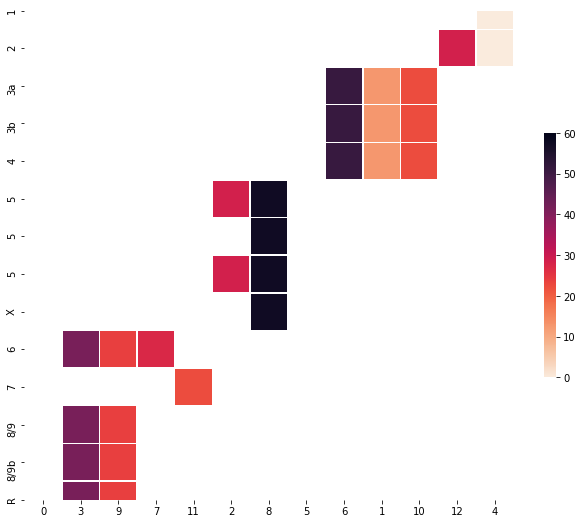

In [85]:
#plot latency onto the correlation map
corr_matrix = np.where(correlation_frame.iloc[13:,0:13]>0.7, 1, np.nan)*latency[ipl_depth_order]*s_per_pixel*1000

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='rocket_r', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           yticklabels=bc_names, xticklabels=cluster_names, vmin=0, vmax=60) #, mask=mask #vmax=0.5, vmin=-0.5

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_Latency.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

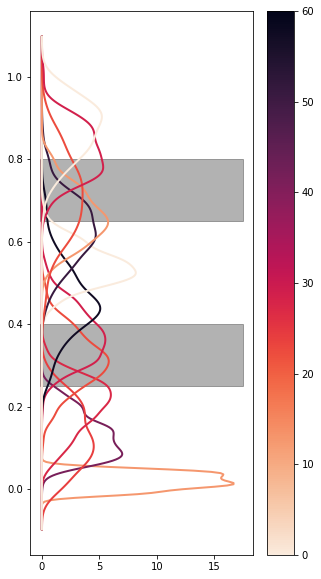

In [86]:
#latency KDE plot
fig = plt.figure(figsize=(5,10))

#make chat bands
xvals, ytop, ybottom = make_chat_bands('on', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)

xvals, ytop, ybottom = make_chat_bands('off', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)


cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True) #center="dark"

x_all = np.array([positions for i in range(13)])
lc = multiline(clusters_kde.T, x_all, latency[ipl_depth_order]*s_per_pixel*1000, cmap='rocket_r', vmin=0, vmax=60, lw=2)

axcb = fig.colorbar(lc)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_latency_kde.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

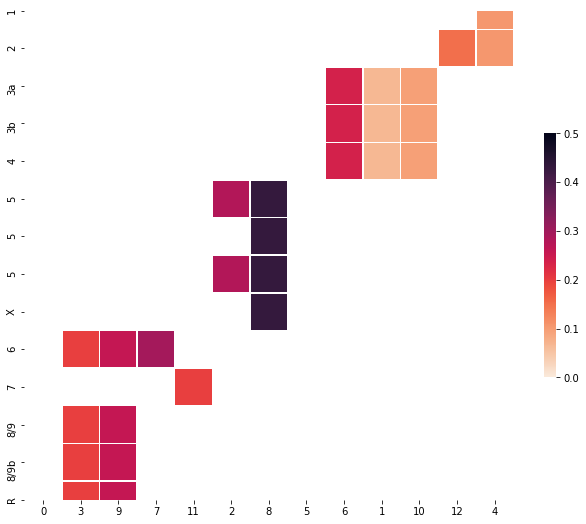

In [87]:
# surround strength correlation map
corr_matrix = np.where(correlation_frame.iloc[13:,0:13]>0.7, 1, np.nan)*surround_strength[ipl_depth_order]*-1

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='rocket_r', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           yticklabels=bc_names, xticklabels=cluster_names, vmin=0, vmax=0.5) #, mask=mask #vmax=0.5, vmin=-0.5

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_surround.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

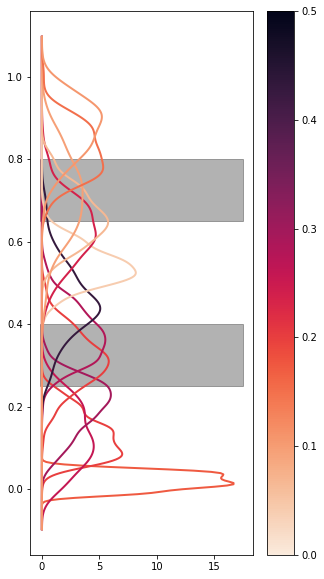

In [88]:
# surround strength KDE

fig = plt.figure(figsize=(5,10))

#make chat bands
xvals, ytop, ybottom = make_chat_bands('on', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)

xvals, ytop, ybottom = make_chat_bands('off', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)

cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True) #center="dark"

x_all = np.array([positions for i in range(13)])
lc = multiline(clusters_kde.T, x_all, surround_strength[ipl_depth_order]*-1, cmap='rocket_r', vmin=0, vmax=0.5, lw=2)

axcb = fig.colorbar(lc)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_surround_kde.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

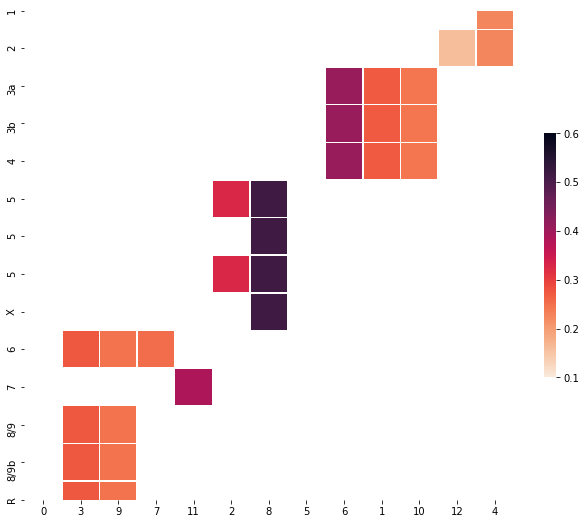

In [89]:
#biphasic index correlation map
corr_matrix = np.where(correlation_frame.iloc[13:,0:13]>0.7, 1, np.nan)*center_biphasic_index[ipl_depth_order]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='rocket_r', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           yticklabels=bc_names, xticklabels=cluster_names, vmin=0.1, vmax=0.6) #, mask=mask #vmax=0.5, vmin=-0.5

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_center_biphasic.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

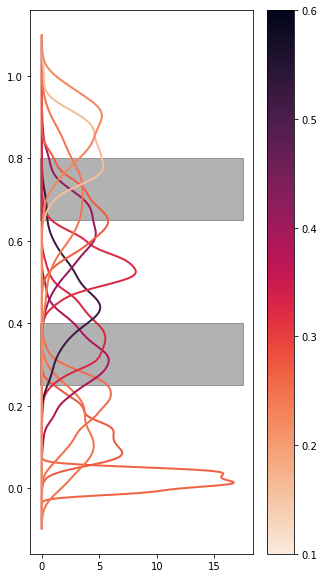

In [90]:
# biphasic index KDE
fig = plt.figure(figsize=(5,10))

#make chat bands
xvals, ytop, ybottom = make_chat_bands('on', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)

xvals, ytop, ybottom = make_chat_bands('off', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)

cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True) #center="dark"

x_all = np.array([positions for i in range(13)])
lc = multiline(clusters_kde.T, x_all, center_biphasic_index[ipl_depth_order], cmap='rocket_r', vmin=0.1, vmax=0.6, lw=2)

axcb = fig.colorbar(lc)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_center_biphasic_kde.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

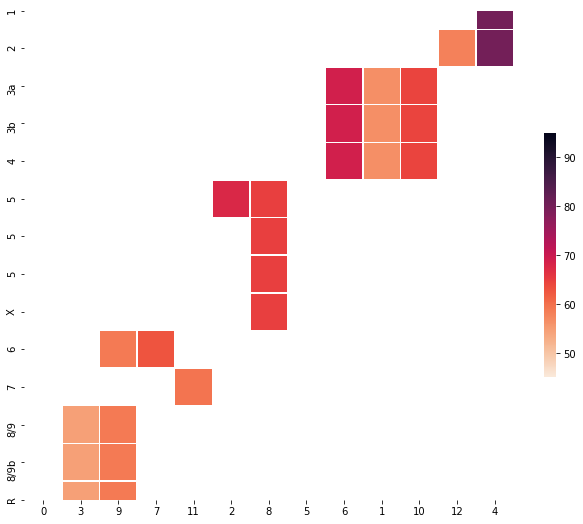

In [91]:
# FWHM correlation plot
corr_matrix = np.where(correlation_frame.iloc[13:,0:13]>0.75, 1, np.nan)*center_fwhm[ipl_depth_order]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='rocket_r', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           yticklabels=bc_names, xticklabels=cluster_names, vmin=45, vmax=95) #, mask=mask #vmax=0.5, vmin=-0.5

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_center_fwhm.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

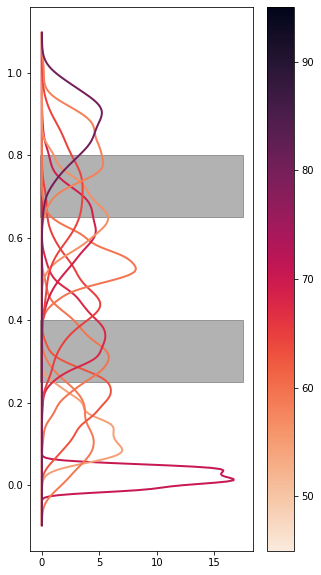

In [92]:
#FWHM KDE plot
fig = plt.figure(figsize=(5,10))

#make chat bands
xvals, ytop, ybottom = make_chat_bands('on', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)

xvals, ytop, ybottom = make_chat_bands('off', -0.15, 17.5)
plt.fill_between(xvals, ytop, ybottom, color='k', alpha=0.3)


cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True) #center="dark"

x_all = np.array([positions for i in range(13)])
lc = multiline(clusters_kde.T, x_all, center_fwhm[ipl_depth_order], cmap='rocket_r', vmin=45, vmax=95, lw=2)

axcb = fig.colorbar(lc)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stratification_center_fwhm_kde.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')